importing libraries and functions needed

In [1]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

import sys 
sys.path.append(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

# data wrangling libs
import numpy as np 
import pandas as pd 
from siuba import * 
from siuba.dply.vector import *

# random methods
from LopezRandomMethod import random_gen_weights
from randomness_by_RogerStafford import randfixedsum 

# UDF: unit circle df (sine and cosine coordinates), dowloading historical stock prices
from unitCircle import unitCircle as unitCircleDf
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns

# graphing
import matplotlib.pyplot as plt 
from plotnine import * 

# optimization
from scipy.optimize import minimize # SLSQP
from simanneal import Annealer # Annealing
from scipy.optimize import dual_annealing

import time  # to time processes 

np.random.seed(1986)


The current working directory is: D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz


creating 3 dataframes of 10,000 random weights each

In [2]:
# creating dataframe of weights from random uniform, r. stafford, and jd. lopez method
n_rows = 10000
n_cols = 30
data = []
data_uniform= []

for _ in range(n_rows):
    row = random_gen_weights(n_cols)
    unif_rand_n=np.random.uniform(low=1,high=100,size=n_cols)
    row_unif = unif_rand_n/unif_rand_n.sum()
    data.append(row)
    data_uniform.append(row_unif)

df_weights_Lopez = pd.DataFrame(data)
df_weights_unif = pd.DataFrame(data_uniform)

rand_RS,v = randfixedsum(30, 10000, 1, 0, 1)
df_weights_RS = pd.DataFrame(rand_RS.T)


In [3]:
#downloading 1 year of data
df_ticker_price = download_data(list_stocks=tickerList,start_date = '2023-08-01', end_date = '2024-09-30')
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)

## returns only
training_1y_endJul2024=df_ticker_price1[:"2024-07-31"].copy()
training_pct_change=training_1y_endJul2024.pct_change().dropna()

[*********************100%***********************]  30 of 30 completed


Calculating sharpe ratio for each of the 10,000 random portfolios for each of the 3 randomization methods

In [4]:
def VectorSharpe(fn_weights: pd.DataFrame) -> np.array:
    port_means= []
    port_sd = []
    for row in fn_weights.values: 
        iter=training_pct_change.dot(row)
        i_mean=iter.mean()
        i_sd = iter.std()
        port_means.append(i_mean*41) # times 41 to get expected return in 41 days (2 months)
        port_sd.append(i_sd * np.sqrt(41))

    array_means = np.array(port_means)
    array_sd = np.array(port_sd)
    return np.column_stack((array_means,array_sd,array_means / array_sd))

In [5]:
df_weights_Lopez[['Port Return','Port SD','Sharpe']]=VectorSharpe(df_weights_Lopez)
df_weights_unif[['Port Return','Port SD','Sharpe']]=VectorSharpe(df_weights_unif)
df_weights_RS[['Port Return','Port SD','Sharpe']]=VectorSharpe(df_weights_RS)


Defining Functions for Optimization Algorithms

In [6]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41 # times 41 b/c there are 41 trading days in August and Sept

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

## SLSQP

#### Setting Constraints and Bounds 
- Constraint: Weights add to 1 
- Bounds: Each weight should be within the [0,1] interval

In [7]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(training_pct_change.shape[1])]

<h3 style= "color: cyan;">Best 100 Portfolios</h3>

In [8]:
from siuba import *
from siuba.dply.vector import *

top100_Lopez=df_weights_Lopez >> arrange(-_.Sharpe) >> _.head(100)
top100_Unif = df_weights_unif>> arrange(-_.Sharpe) >> _.head(100)
top100_RS = df_weights_RS>> arrange(-_.Sharpe) >> _.head(100)

In [10]:
print("Best Sharpe before Optim")

print(top100_Lopez >> top_n(1) >> select(_.Sharpe) )
print(top100_RS >> top_n(1) >> select(_.Sharpe) )
print(top100_Unif >> top_n(1) >> select(_.Sharpe) )


Best Sharpe before Optim
        Sharpe
7242  1.106967
        Sharpe
3062  0.996949
       Sharpe
6191  0.92399


Setting up function to return best Sharpe ratio and best weights out of 100 Portfolios iteration

In [11]:
def best_out_of_100_port_SLSQP(fn_best100:pd.DataFrame):
    # iterating over 100 best portfolios 
    best_result = 0 
    best_weights = 0
    iter_n = 0    

    for i,x in enumerate(fn_best100.values):
        
        #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
        initial_guess = x    
        result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
        
        if -result.fun > best_result: 
            iter_n+=1            
            best_result = -result.fun 
            best_weights = result.x   
            
    return best_result, best_weights
            
            

In [12]:
def calc_EuclideanDistance(points1:np.array, points2:np.array) -> float:
    return np.sqrt(np.sum((points1 - points2) ** 2))

Best Sharpe Lopez vs SLSQP and Best Weights - Using 100 Best Portfolios

In [13]:
Sharpe_Lopez_SLSQP_Best100, Weights_Lopez_SLSQP_Best100 =best_out_of_100_port_SLSQP(top100_Lopez.iloc[:,:30])

In [14]:
print("Lopez vs SLSQP - Best 100 Portfolios\n")

print(f"best Sharpe: {Sharpe_Lopez_SLSQP_Best100}\n") 

print(f"best weights:\n{Weights_Lopez_SLSQP_Best100}")

Lopez vs SLSQP - Best 100 Portfolios

best Sharpe: 1.2881773485774501

best weights:
[3.73970438e-16 1.07278950e-01 7.53845125e-02 9.05855306e-02
 8.45812957e-16 2.99874786e-16 1.15002264e-16 2.74482043e-16
 6.88837165e-17 1.62943444e-16 5.09849257e-16 2.62275427e-02
 1.43402026e-17 1.92756273e-16 9.69706011e-02 1.14886022e-15
 3.79681898e-16 1.22912827e-01 1.48617815e-16 3.79005572e-16
 3.60994550e-02 2.76516754e-16 5.42486579e-02 1.45400329e-15
 7.66869780e-17 3.28734643e-02 4.00395184e-02 9.35099485e-17
 1.12742636e-01 2.04636304e-01]


In [14]:
def distance_array(fn_df_weights:pd.DataFrame, fn_bestWeight:np.array):      
    distance = []

    for weights in fn_df_weights.values: 
        distance.append(calc_EuclideanDistance(weights,fn_bestWeight))

    distance_array = np.array(distance)
    return distance_array


In [15]:
dist_Lopez_SLSQP_best100=distance_array(top100_Lopez.iloc[:,:30], Weights_Lopez_SLSQP_Best100)
print(f"min distance is {dist_Lopez_SLSQP_best100.min().round(2)}")
print(f"max distance is {dist_Lopez_SLSQP_best100.max().round(2)}")
print(f"mean distance is {dist_Lopez_SLSQP_best100.mean().round(2)}")
print(f"median distance is {np.median(dist_Lopez_SLSQP_best100).round(2)}")

min distance is 0.3
max distance is 0.78
mean distance is 0.5
median distance is 0.49


Best Sharpe Stafford vs SLSQP and Best Weights - Using 100 Best Portfolios

In [16]:
Sharpe_Stafford_SLSQP_Best100, Weights_Stafford_SLSQP_Best100 =best_out_of_100_port_SLSQP(top100_RS.iloc[:,:30])
print("Stafford vs SLSQP - Best 100 Portfolios\n")

print(f"best Sharpe: {Sharpe_Stafford_SLSQP_Best100}\n") 

print(f"best weights:\n{Weights_Stafford_SLSQP_Best100}")

Stafford vs SLSQP - Best 100 Portfolios

best Sharpe: 1.2881777674764823

best weights:
[5.48813008e-16 1.07289730e-01 7.54125412e-02 9.06052674e-02
 8.79000432e-17 2.69638111e-16 5.01194875e-16 8.21388753e-17
 3.53872775e-16 4.42756451e-17 1.09765849e-16 2.61709401e-02
 1.77944757e-17 6.90974527e-17 9.69879319e-02 1.53430606e-16
 1.46783720e-16 1.22994885e-01 3.35530644e-16 9.97147110e-17
 3.61131433e-02 5.56367202e-16 5.42161289e-02 1.93291373e-16
 1.85455074e-16 3.28634042e-02 3.99859461e-02 2.34069558e-16
 1.12754124e-01 2.04605957e-01]


In [17]:
dist_Stafford_SLSQP_best100=distance_array(top100_RS.iloc[:,:30], Weights_Stafford_SLSQP_Best100)
print(f"min distance is {dist_Stafford_SLSQP_best100.min().round(2)}")
print(f"max distance is {dist_Stafford_SLSQP_best100.max().round(2)}")
print(f"mean distance is {dist_Stafford_SLSQP_best100.mean().round(2)}")
print(f"median distance is {np.median(dist_Stafford_SLSQP_best100).round(2)}")

min distance is 0.18
max distance is 0.34
mean distance is 0.27
median distance is 0.27


Best Sharpe Unform vs SLSQP and Best Weights - Using 100 Best Portfolios

In [19]:
Sharpe_Uniform_SLSQP_Best100, Weights_Uniform_SLSQP_Best100 =best_out_of_100_port_SLSQP(top100_Unif.iloc[:,:30])
print("Stafford vs SLSQP - Best 100 Portfolios\n")

print(f"best Sharpe: {Sharpe_Uniform_SLSQP_Best100}\n") 

print(f"best weights:\n{Weights_Uniform_SLSQP_Best100}")

Stafford vs SLSQP - Best 100 Portfolios

best Sharpe: 1.2881777820646163

best weights:
[4.10974385e-16 1.07298835e-01 7.53985910e-02 9.05858038e-02
 6.75186316e-16 0.00000000e+00 5.77379895e-17 6.55900715e-17
 1.72319060e-16 4.89188043e-16 9.51581572e-17 2.61990884e-02
 1.21391499e-16 7.43731385e-17 9.69813001e-02 2.61164115e-16
 1.71615212e-17 1.22952476e-01 1.82506345e-16 3.28837397e-17
 3.60942926e-02 3.08013449e-16 5.42233259e-02 2.15092935e-16
 1.67728016e-16 3.28741093e-02 4.00364157e-02 2.41709992e-16
 1.12729926e-01 2.04625836e-01]


In [20]:
dist_Unif_SLSQP_best100=distance_array(top100_Unif.iloc[:,:30], Weights_Uniform_SLSQP_Best100)
print(f"min distance is {dist_Unif_SLSQP_best100.min().round(2)}")
print(f"max distance is {dist_Unif_SLSQP_best100.max().round(2)}")
print(f"mean distance is {dist_Unif_SLSQP_best100.mean().round(2)}")
print(f"median distance is {np.median(dist_Unif_SLSQP_best100).round(2)}")

min distance is 0.23
max distance is 0.31
mean distance is 0.27
median distance is 0.27


In [21]:
def print_distance_metrics(fn_distance:np.array)->None:
    print(f"min distance is {fn_distance.min().round(2)}")
    print(f"max distance is {fn_distance.max().round(2)}")
    print(f"mean distance is {fn_distance.mean().round(2)}")
    print(f"median distance is {np.median(fn_distance).round(2)}")

Putting that whole process into a single function

In [22]:

def metrics_table_SLSQP(fn_df_weights:pd.DataFrame):
    startTime = time.time()
    fn_Sharpe_result, fn_Weights_result =best_out_of_100_port_SLSQP(fn_df_weights.iloc[:,:30])
    endTime= time.time()
    timeElapsed = endTime - startTime

    fn_distance_result=distance_array(fn_df_weights.iloc[:,:30], fn_Weights_result)
    
    return timeElapsed,fn_Sharpe_result, fn_Weights_result, fn_distance_result




In [18]:
# top100_Unif
time_Unif_SLSQP_best100, sharpe_Unif_SLSQP_best100, weights_Unif_SLSQP_best100, vector_distance_Unif_SLSQP_best100=metrics_table_SLSQP(top100_Unif)


In [23]:
def print_summary_table(fn_time, fn_sharpe, fn_distance)-> None:
    print(f"time optim process took: {fn_time:.2f} seconds")
    print(f"best sharpe after optim: {fn_sharpe}")
    print_distance_metrics(fn_distance)


In [20]:
print_summary_table(time_Unif_SLSQP_best100, sharpe_Unif_SLSQP_best100, vector_distance_Unif_SLSQP_best100)

time optim process took: 51.12 seconds
best sharpe after optim: 1.2881774984081575
min distance is 0.23
max distance is 0.31
mean distance is 0.27
median distance is 0.27


<h3 style= "color: cyan;">Worst 100 Portfolios</h3>

In [22]:
worst100_Lopez=df_weights_Lopez >> arrange(_.Sharpe) >> _.head(100)
worst100_Unif = df_weights_unif>> arrange(_.Sharpe) >> _.head(100)
worst100_RS = df_weights_RS>> arrange(_.Sharpe) >> _.head(100)

In [189]:
time_Lopez_SLSQP_worst100, sharpe_Lopez_SLSQP_worst100, weights_Lopez_SLSQP_worst100, vector_distance_Lopez_SLSQP_worst100=metrics_table_SLSQP(worst100_Lopez)
print_summary_table(time_Lopez_SLSQP_worst100, sharpe_Lopez_SLSQP_worst100, vector_distance_Lopez_SLSQP_worst100)

time optim process took: 14.88 seconds
best sharpe after optim: 1.2881778984039243
min distance is 0.64
max distance is 1.05
mean distance is 0.91
median distance is 0.93


In [190]:
time_RS_SLSQP_worst100, sharpe_RS_SLSQP_worst100, weights_RS_SLSQP_worst100, vector_distance_RS_SLSQP_worst100=metrics_table_SLSQP(worst100_RS)
print_summary_table(time_RS_SLSQP_worst100, sharpe_RS_SLSQP_worst100, vector_distance_RS_SLSQP_worst100)

time optim process took: 10.06 seconds
best sharpe after optim: 1.2881778856071935
min distance is 0.33
max distance is 0.44
mean distance is 0.38
median distance is 0.38


In [191]:
time_Unif_SLSQP_worst100, sharpe_Unif_SLSQP_worst100, weights_Unif_SLSQP_worst100, vector_distance_Unif_SLSQP_worst100=metrics_table_SLSQP(worst100_Unif)
print_summary_table(time_Unif_SLSQP_worst100, sharpe_Unif_SLSQP_worst100, vector_distance_Unif_SLSQP_worst100)

time optim process took: 10.06 seconds
best sharpe after optim: 1.2881778786794706
min distance is 0.3
max distance is 0.36
mean distance is 0.33
median distance is 0.34


<h3 style= "color: cyan;">Random 100 Portfolios</h3>

In [ ]:
np.random.seed(1986)
random100_Lopez = df_weights_Lopez.sample(n=100,replace=False)
random100_Unif = df_weights_unif.sample(n=100,replace=False)
random100_RS = df_weights_RS.sample(n=100,replace=False)

In [148]:
time_Lopez_SLSQP_random100, sharpe_Lopez_SLSQP_random100, weights_Lopez_SLSQP_random100, vector_distance_Lopez_SLSQP_random100=metrics_table_SLSQP(random100_Lopez)
print_summary_table(time_Lopez_SLSQP_random100, sharpe_Lopez_SLSQP_random100, vector_distance_Lopez_SLSQP_random100)

time optim process took: 11.09 seconds
best sharpe after optim: 1.2881778770461427
min distance is 0.44
max distance is 1.03
mean distance is 0.7
median distance is 0.69


In [149]:
time_RS_SLSQP_random100, sharpe_RS_SLSQP_random100, weights_RS_SLSQP_random100, vector_distance_RS_SLSQP_random100=metrics_table_SLSQP(random100_RS)
print_summary_table(time_RS_SLSQP_random100, sharpe_RS_SLSQP_random100, vector_distance_RS_SLSQP_random100)

time optim process took: 11.21 seconds
best sharpe after optim: 1.2881778875975756
min distance is 0.24
max distance is 0.45
mean distance is 0.33
median distance is 0.33


In [150]:
time_Unif_SLSQP_random100, sharpe_Unif_SLSQP_random100, weights_Unif_SLSQP_random100, vector_distance_Unif_SLSQP_random100=metrics_table_SLSQP(random100_Unif)
print_summary_table(time_Unif_SLSQP_random100, sharpe_Unif_SLSQP_random100, vector_distance_Unif_SLSQP_random100)

time optim process took: 11.57 seconds
best sharpe after optim: 1.2881779074684023
min distance is 0.26
max distance is 0.34
mean distance is 0.3
median distance is 0.3


## Annealing

In [21]:

class PortfolioOptimization_Annealing(Annealer):
    def __init__(self, state, returns):
        self.returns = returns
        super().__init__(state)

    def move(self):
        """ Randomly adjust a weight """
        i = np.random.randint(0, len(self.state))
        change = np.random.uniform(-0.1, 0.1)
        self.state[i] = min(max(self.state[i] + change, 0), 1)
        self.state = self.state / np.sum(self.state)

    def energy(self):
        return sharpe_ratio(self.state, self.returns)

In [22]:
def optim_annealer(fn_init_weights:np.array):
    optimizer = PortfolioOptimization_Annealing(fn_init_weights, training_pct_change)
    optimizer.steps = 10000
    fn_weight_result, fn_sharpe_result = optimizer.anneal()
    return fn_weight_result, fn_sharpe_result

In [23]:
def best_out_of_100_port_Annealer(fn_best100:pd.DataFrame):
    # iterating over 100 best portfolios 
    best_result = 0 
    best_weights = 0
    iter_n = 0    

    for i,x in enumerate(fn_best100.values):
        
        #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
        initial_guess = x    
        result_weight, result_sharpe = optim_annealer(x)
        
        if -result_sharpe > best_result: 
            iter_n+=1            
            best_result = -result_sharpe
            best_weights = result_weight  
            
    return best_result, best_weights
            
            

In [165]:
def metrics_table_Annealing(fn_df_weights:pd.DataFrame):
    startTime = time.time()
    fn_Sharpe_result, fn_Weights_result =best_out_of_100_port_Annealer(fn_df_weights.iloc[:,:30])
    endTime= time.time()
    timeElapsed = endTime - startTime

    fn_distance_result=distance_array(fn_df_weights.iloc[:,:30], fn_Weights_result)
    
    return timeElapsed,fn_Sharpe_result, fn_Weights_result, fn_distance_result

<h3 style= "color: cyan;">Best 100 Portfolios</h3>

In [166]:
time_Lopez_Anneal_best100, sharpe_Lopez_Anneal_best100, weights_Lopez_Anneal_best100, vector_distance_Lopez_Anneal_best100=metrics_table_Annealing(top100_Lopez)
print_summary_table(time_Lopez_Anneal_best100, sharpe_Lopez_Anneal_best100, vector_distance_Lopez_Anneal_best100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.74   100.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.38   100.00%    38.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.72   100.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.82    99.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.64   100.00%    51.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.77    99.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.41   100.00%    43.00%     0:00:04     0:00:00 Temperature 

time optim process took: 337.58 seconds
best sharpe after optim: 1.1544947943762291
min distance is 0.32
max distance is 0.79
mean distance is 0.53
median distance is 0.52


In [167]:
time_RS_Anneal_best100, sharpe_RS_Anneal_best100, weights_RS_Anneal_best100, vector_distance_RS_Anneal_best100=metrics_table_Annealing(top100_RS)
print_summary_table(time_RS_Anneal_best100, sharpe_RS_Anneal_best100, vector_distance_RS_Anneal_best100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.73    99.00%    50.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.62   100.00%    43.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.55   100.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.27   100.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.48    98.00%    40.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.82   100.00%    53.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.71    99.00%    39.00%     0:00:03     0:00:00 Temperature 

time optim process took: 334.59 seconds
best sharpe after optim: 1.1335574416146703
min distance is 0.18
max distance is 0.35
mean distance is 0.27
median distance is 0.27


In [168]:
time_Unif_Anneal_best100, sharpe_Unif_Anneal_best100, weights_Unif_Anneal_best100, vector_distance_Unif_Anneal_best100=metrics_table_Annealing(top100_Unif)
print_summary_table(time_Unif_Anneal_best100, sharpe_Unif_Anneal_best100, vector_distance_Unif_Anneal_best100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.68   100.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.59   100.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.21   100.00%    47.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.51   100.00%    44.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.83    99.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.41   100.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.72    99.00%    41.00%     0:00:03     0:00:00 Temperature 

time optim process took: 334.85 seconds
best sharpe after optim: 1.0923722944977785
min distance is 0.17
max distance is 0.26
mean distance is 0.21
median distance is 0.21


<h3 style= "color: cyan;">Worst 100 Portfolios</h3>

In [192]:
time_Lopez_Anneal_worst100, sharpe_Lopez_Anneal_worst100, weights_Lopez_Anneal_worst100, vector_distance_Lopez_Anneal_worst100=metrics_table_Annealing(worst100_Lopez)
print_summary_table(time_Lopez_Anneal_worst100, sharpe_Lopez_Anneal_worst100, vector_distance_Lopez_Anneal_worst100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.47   100.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.85   100.00%    47.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.62    99.00%    40.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.49   100.00%    40.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.75    98.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.61   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.64    99.00%    42.00%     0:00:03     0:00:00 Temperature 

time optim process took: 336.62 seconds
best sharpe after optim: 1.1019029969336023
min distance is 0.62
max distance is 1.05
mean distance is 0.9
median distance is 0.91


In [193]:
time_RS_Anneal_worst100, sharpe_RS_Anneal_worst100, weights_RS_Anneal_worst100, vector_distance_RS_Anneal_worst100=metrics_table_Annealing(worst100_RS)
print_summary_table(time_RS_Anneal_worst100, sharpe_RS_Anneal_worst100, vector_distance_RS_Anneal_worst100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.65    98.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.36   100.00%    46.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.57   100.00%    34.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.65   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.69   100.00%    39.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.60   100.00%    44.00%     0:00:03     0:00:00 Temperature 

time optim process took: 339.04 seconds
best sharpe after optim: 1.154494794376229
min distance is 0.3
max distance is 0.4
mean distance is 0.34
median distance is 0.34


In [194]:
time_Unif_Anneal_worst100, sharpe_Unif_Anneal_worst100, weights_Unif_Anneal_worst100, vector_distance_Unif_Anneal_worst100=metrics_table_Annealing(worst100_Unif)
print_summary_table(time_Unif_Anneal_worst100, sharpe_Unif_Anneal_worst100, vector_distance_Unif_Anneal_worst100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.32   100.00%    40.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.29    98.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.50   100.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.71   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63    99.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.58   100.00%    36.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.36   100.00%    42.00%     0:00:03     0:00:00 Temperature 

time optim process took: 345.36 seconds
best sharpe after optim: 1.1412100821488351
min distance is 0.27
max distance is 0.34
mean distance is 0.3
median distance is 0.31


<h3 style= "color: cyan;">Random 100 Portfolios</h3>

In [172]:
time_RS_Anneal_random100, sharpe_RS_Anneal_random100, weights_RS_Anneal_random100, vector_distance_RS_Anneal_random100=metrics_table_Annealing(random100_RS)
print_summary_table(time_RS_Anneal_random100, sharpe_RS_Anneal_random100, vector_distance_RS_Anneal_random100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.74    99.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.42   100.00%    33.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.41   100.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63   100.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.14   100.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.73    99.00%    44.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.90   100.00%    50.00%     0:00:03     0:00:00 Temperature 

time optim process took: 332.53 seconds
best sharpe after optim: 1.1377350389641963
min distance is 0.21
max distance is 0.43
mean distance is 0.27
median distance is 0.27


In [173]:
time_Lopez_Anneal_random100, sharpe_Lopez_Anneal_random100, weights_Lopez_Anneal_random100, vector_distance_Lopez_Anneal_random100=metrics_table_Annealing(random100_Lopez)
print_summary_table(time_Lopez_Anneal_random100, sharpe_Lopez_Anneal_random100, vector_distance_Lopez_Anneal_random100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.66   100.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.55   100.00%    47.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.79    99.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.47    99.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63    99.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.44   100.00%    50.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.65   100.00%    45.00%     0:00:03     0:00:00 Temperature 

time optim process took: 335.55 seconds
best sharpe after optim: 1.127809592443572
min distance is 0.42
max distance is 1.02
mean distance is 0.7
median distance is 0.69


In [174]:
time_Unif_Anneal_random100, sharpe_Unif_Anneal_random100, weights_Unif_Anneal_random100, vector_distance_Unif_Anneal_random100=metrics_table_Annealing(random100_Unif)
print_summary_table(time_Unif_Anneal_random100, sharpe_Unif_Anneal_random100, vector_distance_Unif_Anneal_random100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.43   100.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.58   100.00%    43.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.58    97.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.40   100.00%    44.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.74   100.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.85    99.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.39   100.00%    34.00%     0:00:03     0:00:00 Temperature 

time optim process took: 363.53 seconds
best sharpe after optim: 1.1099993981022294
min distance is 0.23
max distance is 0.31
mean distance is 0.27
median distance is 0.27


## Dual Annealing

In [211]:
def fn_dualAnnealing():
        
    returns = training_pct_change # 41 days of returns for 30 stocks

    # Set the bounds for the weights (0 to 1)
    bounds = [(0, 1) for _ in range(returns.shape[1])]

    # Define a penalty function for weights sum constraint
    def penalty(weights):
        return 1000 * abs(np.sum(weights) - 1)

    # Cost function with penalty
    def cost_function(weights, returns):
        return sharpe_ratio(weights, returns) + penalty(weights)
    # Constraint for the sum of weights to be 1
    #constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})


    # Optimize using dual_annealing
    result = dual_annealing(lambda weights: cost_function(weights, returns),
                            bounds=bounds)
    
    return result.x, -result.fun


In [214]:
def best_out_of_100_port_DualAnnealer():
    # iterating over 100 best portfolios 
    best_result = 0 
    best_weights = 0
    iter_n = 0    

    for i,x in enumerate(range(100)):                
        result_weight, result_sharpe = fn_dualAnnealing()
        
        if result_sharpe > best_result: 
            iter_n+=1            
            best_result =  result_sharpe
            best_weights = result_weight  
            
    return best_result, best_weights

In [215]:
def metrics_table_DualAnnealing(fn_df_weights:pd.DataFrame):
    startTime = time.time()
    fn_Sharpe_result, fn_Weights_result =best_out_of_100_port_DualAnnealer()
    endTime= time.time()
    timeElapsed = endTime - startTime

    fn_distance_result=distance_array(fn_df_weights.iloc[:,:30], fn_Weights_result)
    
    return timeElapsed,fn_Sharpe_result, fn_Weights_result, fn_distance_result

In [219]:
time_DualAnneal, sharpe_DualAnneal, weights_DualAnneal, vector_distance_DualAnneal=metrics_table_DualAnnealing(worst100_Lopez)
print_summary_table(time_DualAnneal, sharpe_DualAnneal, vector_distance_DualAnneal)

time optim process took: 2131.66 seconds
best sharpe after optim: 1.0544882944926117
min distance is 0.59
max distance is 1.03
mean distance is 0.88
median distance is 0.9


## Quick Parenthesis on Dow Jones vs Equal Weights

In [18]:
#filtering for latest date 
weights_DJI=training_1y_endJul2024 >> \
      filter(_.index == _.index.max()) >> \
        _.apply(lambda x: x/sum(x), axis=1) >> _.iloc[0,:]

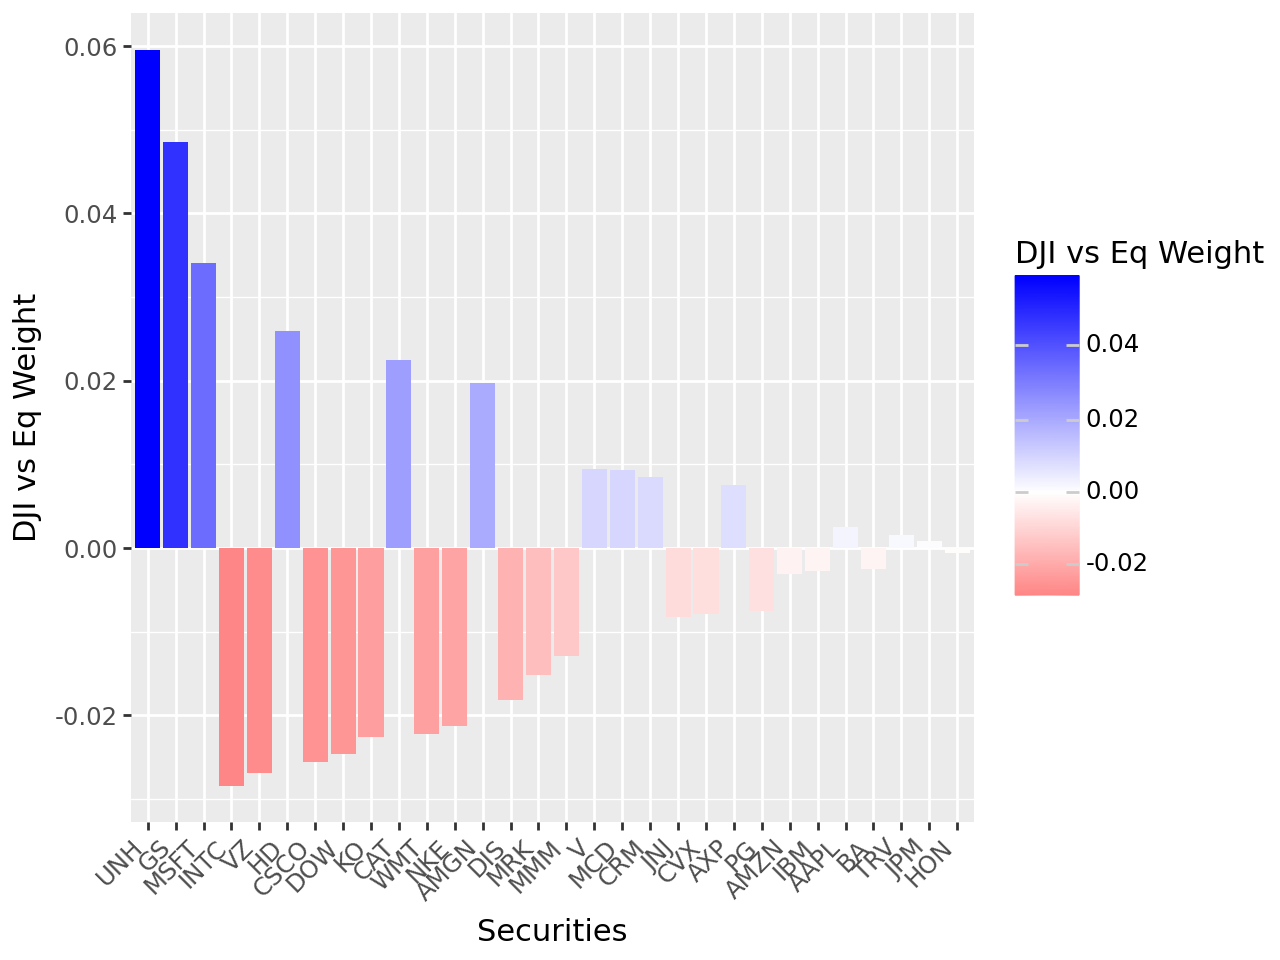

In [20]:
## graph for chapter 3 to explain how weights have changed given a right shift from the equal weightred portfolio
graphCH3=pd.DataFrame({'DJI vs Eq Weight':weights_DJI - (1/30)}) >> \
    mutate(abs_diff = abs(_['DJI vs Eq Weight']), inv_diff = -_['DJI vs Eq Weight']) >> \
arrange(-_.abs_diff) >> _.reset_index() >> \
    ggplot() + geom_col(aes(x='reorder(index, -abs_diff)',y='DJI vs Eq Weight', fill='DJI vs Eq Weight'))+\
    scale_fill_gradient2(low='red', mid='white', high='blue', midpoint=0)+theme(axis_text_x=element_text(rotation=45, hjust=1))+\
    labs(x='Securities')
graphCH3

In [21]:
graphCH3.save(filename='CH3 graph explain weights',dpi=1000)

<h3 style="color:cyan;">Performance of DJI</h3>

In [23]:
-sharpe_ratio(weights_DJI,training_pct_change)

0.778604018303849

In [24]:
# best portfolio sharpe vs dji's sharpe is 65% better
1.28/.7788

1.6435541859270673

In [25]:
-sharpe_ratio(Weights_Lopez_SLSQP_Best100,training_pct_change)

1.2881774956496634

In [26]:
portfolio_risk(weights_DJI,training_pct_change)

0.040957309499411135

In [27]:
portfolio_risk(Weights_Lopez_SLSQP_Best100,training_pct_change)

0.041076718243642035

In [28]:
portfolio_return(weights_DJI,training_pct_change)

0.03188952575515591

In [29]:
portfolio_return(Weights_Lopez_SLSQP_Best100,training_pct_change)

0.052914104036601635

In [30]:
0.0529/0.0318

1.6635220125786163

<h3 style="color:cyan;">Historical Performance of DJI</h3>

In [8]:
from datetime import date, datetime, timedelta

start_date = date(2023,8,1)
end_date = date(2024,7,31)


In [9]:
def prev_startdate(fn_startDate: date):
    return (fn_startDate - timedelta(days=1)).replace(day=1)

In [10]:
def prev_enddate(fn_endDate:date): 
    return fn_endDate.replace(day=1) - timedelta(days=1)

In [11]:
import yfinance as yf

# Define the ticker symbol for Dow Jones Industrial Average
ticker = '^DJI'

# Download historical data
djia_data = yf.download(ticker, start='2020-01-01', end='2024-08-01')
dji_pricehist=missing_days_andIndexTimeZone(djia_data['Close'])

[*********************100%***********************]  1 of 1 completed


In [12]:
def fn_get_histPrice(fn_startFecha:date, fn_endFecha:date)->pd.DataFrame:
    #downloading 1 year of data
    df_ticker = download_data(list_stocks=tickerList,start_date = fn_startFecha.strftime('%Y-%m-%d'), end_date = fn_endFecha.strftime('%Y-%m-%d'))
    df_tickerprice1=missing_days_andIndexTimeZone(df_ticker)
    return df_tickerprice1
    ## returns only    
    #training_pct_change=df_tickerprice1.pct_change().dropna()

In [13]:
full_hist_prices=fn_get_histPrice(date(2020,1,1),date(2024,8,1))

[*********************100%***********************]  30 of 30 completed


In [14]:
def fn_get_DJI_mean_std(fn_prices:pd.DataFrame, start_date:date, end_date:date):
    df_DJI_results=fn_prices.reset_index() >> filter(_.Date >= start_date.strftime('%Y-%m-%d'),_.Date < end_date.strftime('%Y-%m-%d')) >> \
    mutate(price_change = _.Close.pct_change()) >> _.dropna() >> summarize(mean_change_price = _.price_change.mean()*41, 
                                                                           std_price = _.price_change.std()*np.sqrt(41)
                                                                           ) >> mutate(sharpe1 = _.mean_change_price/_.std_price)

    return df_DJI_results.loc[0,'mean_change_price'], df_DJI_results.loc[0,'std_price']
    # pct_change_dji = (fn_prices.apply(lambda x: x/sum(x), axis=1) * fn_prices).sum(axis=1).pct_change().dropna()
    # return pct_change_dji.mean()*41, pct_change_dji.std()*np.sqrt(41)

In [15]:
def fn_getPctChange(fn_prices:pd.DataFrame)->pd.DataFrame: 
    return fn_prices.pct_change().dropna()

In [16]:
def returnDf_results(stDate:date, enDate:date,return_DJI, risk_DJI, return_bestPortfolio, risk_bestPortfolio, best_weights): 
    return pd.DataFrame(
        {
            'startDate': [stDate],
            'endDate': [enDate],
            'DJI_return': [return_DJI],
            'DJI_risk': [risk_DJI],
            'BestPort_return': [return_bestPortfolio],
            'BestPort_risk': [risk_bestPortfolio], 
            'Best_Weights': [best_weights]

        }
    )


## Comparacion Mes a Mes de DJI vs SLSQP Inicial
Se utiliza para ver mes a mes las comparaciones del capitulo 4 antes de ocuapr bootstrap

In [22]:
start_date = date(2023,8,1)
end_date = date(2024,8,1)
from siuba import *
full_hist_prices >> filter(_.index >= start_date.strftime('%Y-%m-%d'), 
                           _.index < end_date.strftime('%Y-%m-%d')) >> _.head(2)

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-01,194.138107,221.757538,131.690002,166.956696,238.009995,282.633057,223.278793,50.634239,152.516861,88.333260,...,86.664322,101.866035,332.463440,107.381104,151.498367,167.959595,495.241302,237.009903,30.686533,52.144875
2023-08-02,191.130905,220.123871,128.210007,164.102737,231.380005,281.575592,219.525452,50.557316,150.101761,85.624626,...,85.370941,102.272415,323.725311,105.525970,151.828049,166.780167,495.300171,234.815552,30.585564,52.180927


In [23]:
from siuba import *
startingDf = pd.DataFrame(
        {
            'startDate':[],
            'endDate':[],
            'DJI_return': [],
            'DJI_risk': [],
            'BestPort_return': [],
            'BestPort_risk': [], 
            'Best_Weights': []

        }
    )
start_date = date(2023,8,1)
end_date = date(2024,8,1)
while True: 
    if start_date < date(2020,1,1):
        break 
    else: 
        df_prices_iter=full_hist_prices >> filter(_.index >= start_date.strftime('%Y-%m-%d'), 
                           _.index < end_date.strftime('%Y-%m-%d'))
        
        
        #df_prices_iter=fn_get_histPrice(start_date,end_date)
        dji_mean_iter, dji_risk_iter=fn_get_DJI_mean_std(dji_pricehist, start_date=start_date,end_date=end_date)   
         
        df_returns_iter = fn_getPctChange(df_prices_iter)
        
        result_SLSQP_iter = minimize(sharpe_ratio, np.full(30, 1/30), args=(df_returns_iter,), 
                                     method='SLSQP', 
                                     bounds=bounds, constraints=constraints)
        
        best_weights_iter = result_SLSQP_iter.x 
        bestPort_return_iter=portfolio_return(best_weights_iter,df_returns_iter)
        bestPort_risk_iter=portfolio_risk(best_weights_iter,df_returns_iter)

        df_iter=returnDf_results(start_date, end_date, dji_mean_iter,dji_risk_iter, bestPort_return_iter,bestPort_risk_iter, best_weights_iter )
        startingDf = pd.concat([startingDf,df_iter])

        start_date = prev_startdate(start_date)
        end_date = prev_startdate(end_date)

In [24]:
startingDf

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[0.0, 0.1072101997788303, 0.07528896750708303,..."
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[2.6350157316531213e-16, 0.09584734256413022, ..."
0,2023-06-01,2024-06-01,0.025479,0.039867,0.059366,0.042927,"[2.1341323135053496e-16, 0.09236057818453017, ..."
0,2023-05-01,2024-05-01,0.017265,0.039876,0.056715,0.047091,"[8.631253285847324e-17, 5.599134782894761e-16,..."
0,2023-04-01,2024-04-01,0.027593,0.038933,0.064838,0.041744,"[4.723128439745467e-16, 1.4254146573654126e-16..."
0,2023-03-01,2024-03-01,0.028735,0.042056,0.066850,0.044615,"[1.84710684095872e-16, 1.6753746764576736e-16,..."
0,2023-02-01,2024-02-01,0.018661,0.043132,0.057325,0.046694,"[1.7089148313431485e-16, 0.10790031543106182, ..."
0,2023-01-01,2024-01-01,0.021352,0.045201,0.072912,0.059408,"[0.14440258744951032, 0.0, 0.05031420234933416..."
0,2022-12-01,2023-12-01,0.008096,0.047394,0.068596,0.076352,"[0.0, 0.0, 0.018457868926830923, 0.0, 0.124417..."
0,2022-11-01,2023-11-01,0.003218,0.051131,0.044233,0.060238,"[0.0, 6.215921738438293e-16, 0.0, 0.0, 0.15655..."


In [92]:
full_hist_prices.to_excel('example_all_prices.xlsx')

In [94]:
startingDf.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[1.7283537882134548e-16, 0.10721013845311782, ..."
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[5.985076454526615e-17, 0.095847590167013, 0.0..."


### Ejemplo Proyecto Personal

In [146]:
def fn_dollarChangePortfolio(fn_portReturn: np.array,
                             init_dollar: int = 1_000_000 )->list[float]:    
    """ 
        This function will return the variability of money in time given portfolio returns as input and a dollar amt
    """    
    from copy import deepcopy 
    dollar_current = deepcopy(init_dollar)
    dollar_changes = []

    for x in fn_portReturn: 
        dollar_current*=(1+x)
        dollar_changes.append(dollar_current)

    return dollar_changes

In [234]:
startingDf.loc[startingDf.startDate == date(2023,8,1),"Best_Weights"][0]#.startDate.values == date(2023,8,1)

array([1.72835379e-16, 1.07210138e-01, 7.52890325e-02, 9.05558555e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18940877e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.61819968e-02,
       1.52984820e-16, 6.98327985e-16, 9.71566124e-02, 0.00000000e+00,
       2.17851603e-16, 1.22887173e-01, 2.59268981e-16, 0.00000000e+00,
       3.60999648e-02, 1.47842581e-16, 5.43699531e-02, 0.00000000e+00,
       0.00000000e+00, 3.27985279e-02, 4.00963323e-02, 1.03600814e-16,
       1.12721911e-01, 2.04632502e-01])

In [235]:
from dateutil.relativedelta import relativedelta
from datetime import date 
# get the last date of each time period 
exampleStartDate = '2023-06-01'
exampleEndDate = '2024-06-01'

def fn_get_max_date_trainingPeriod(fn_startDate:str, fn_endDate:str): 
    fn_timeStamp =full_hist_prices >> filter(_.index >= fn_startDate, _.index < fn_endDate) >> _.index.max()
    return fn_timeStamp


max_date_Trainingperiod = fn_get_max_date_trainingPeriod(exampleStartDate,exampleEndDate)
exampleWeights = startingDf.loc[startingDf.startDate == date(2023,6,1),"Best_Weights"][0]#startingDf.Best_Weights.to_list()[0]

def fn_getPricePortfolio_endTrainingPeriod(fn_maxDateTrainPeriod, fn_weights)->float:
    '''   
        returns price  
    '''
    fn_df_allPrices=full_hist_prices >> filter(_.index == fn_maxDateTrainPeriod )

    return ((fn_df_allPrices.values).dot(fn_weights))[0]

def fn_add_n_months(fn_date:str,fn_n:int)->date:
    fn_str_todate = pd.to_datetime(fn_date).date() 
    return fn_str_todate+ relativedelta(months=fn_n)

endingTrainingPortPrice = fn_getPricePortfolio_endTrainingPeriod(max_date_Trainingperiod, exampleWeights)
last_date_Test = fn_add_n_months(exampleEndDate, 2)


#allReturnsTestingPeriod = 

def fn_get30stockshistReturn(fn_maxTrainPeriod:str, fn_lastDateTest:date)->pd.DataFrame: 
    return full_hist_prices >> filter(_.index >= fn_maxTrainPeriod,_.index < fn_lastDateTest.strftime('%Y-%m-%d')) >> _.pct_change().dropna()

ret_all_30stocks_testPeriod=fn_get30stockshistReturn(max_date_Trainingperiod, last_date_Test)

vector_return_slsqp_Testperiod = ret_all_30stocks_testPeriod.dot(exampleWeights)
vector_dollar_Change = fn_dollarChangePortfolio(vector_return_slsqp_Testperiod,endingTrainingPortPrice )

return_Testperiod_slsqp = vector_dollar_Change[-1]/endingTrainingPortPrice-1

daily_risk_slsqp_test = vector_return_slsqp_Testperiod.std()
risk_2months_slsqp = daily_risk_slsqp_test * np.sqrt(len(vector_return_slsqp_Testperiod)) 



#return_Testperiod_slsqp

#################### dow jones 

# precio init, precio fin 
# volatilidad 

max_testDate_DJI=dji_pricehist[dji_pricehist.index < last_date_Test.strftime('%Y-%m-%d')] >> _.index.max()
price_dji_endTestPeriod=dji_pricehist[dji_pricehist.index == max_testDate_DJI][0]
price_dji_endTrainPeriod=dji_pricehist[dji_pricehist.index == max_date_Trainingperiod][0]

return_Testperiod_DJI = price_dji_endTestPeriod/price_dji_endTrainPeriod - 1 

df_test_DJI = dji_pricehist[(dji_pricehist.index >= max_date_Trainingperiod) & 
                            (dji_pricehist.index <= max_testDate_DJI)]

daily_risk_DJI_test=df_test_DJI.pct_change().dropna().std()
risk_2months_DJI = daily_risk_DJI_test * np.sqrt(len(vector_return_slsqp_Testperiod)) 


print(f"return SLSQP: {return_Testperiod_slsqp:.4f}\nreturn DJI: {return_Testperiod_DJI:.4f}")
print("")
print(f"risk SLSQP: {risk_2months_slsqp:.4f}\nrisk DJI: {risk_2months_DJI:.4f}")
print("")
print(f"sharpe SLSQP: {return_Testperiod_slsqp/risk_2months_slsqp:.4f}\nsharpe DJI: {return_Testperiod_DJI/risk_2months_DJI:.4f} \nsharpe SLSQP/sharpe DJI = {(return_Testperiod_slsqp/risk_2months_slsqp)/(return_Testperiod_DJI/risk_2months_DJI):.4f}")

# df_test_result = pd.DataFrame({
#     'startDate': [],
#     'return_SLSQP': [return_Testperiod_slsqp],

# })

# last_date_Test

return SLSQP: 0.0498
return DJI: 0.0557

risk SLSQP: 0.0397
risk DJI: 0.0391

sharpe SLSQP: 1.2533
sharpe DJI: 1.4269 
sharpe SLSQP/sharpe DJI = 0.8783


In [190]:
startingDf.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[1.7283537882134548e-16, 0.10721013845311782, ..."
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[5.985076454526615e-17, 0.095847590167013, 0.0..."


In [199]:
test_results = pd.DataFrame({
    'startDate': [],
    'endDate': [],
    'SLSQP_Return': [],
    'SLSQP_risk': [],
    'DJI_Return': [],
    'DJI_risk':[]

})

for row in startingDf.values: 
    exampleStartDate = row[0].strftime('%Y-%m-%d')
    exampleEndDate = row[1].strftime('%Y-%m-%d')    
        
    max_date_Trainingperiod = fn_get_max_date_trainingPeriod(exampleStartDate,exampleEndDate)
    exampleWeights = row[-1]
    
    
    endingTrainingPortPrice = fn_getPricePortfolio_endTrainingPeriod(max_date_Trainingperiod, exampleWeights)
    last_date_Test = fn_add_n_months(exampleEndDate, 2)
        
    ret_all_30stocks_testPeriod=fn_get30stockshistReturn(max_date_Trainingperiod, last_date_Test)

    vector_return_slsqp_Testperiod = ret_all_30stocks_testPeriod.dot(exampleWeights)
    vector_dollar_Change = fn_dollarChangePortfolio(vector_return_slsqp_Testperiod,endingTrainingPortPrice )

    return_Testperiod_slsqp = vector_dollar_Change[-1]/endingTrainingPortPrice-1

    daily_risk_slsqp_test = vector_return_slsqp_Testperiod.std()
    risk_2months_slsqp = daily_risk_slsqp_test * np.sqrt(len(vector_return_slsqp_Testperiod)) 


    #################### dow jones 

    max_testDate_DJI=dji_pricehist[dji_pricehist.index < last_date_Test.strftime('%Y-%m-%d')] >> _.index.max()
    price_dji_endTestPeriod=dji_pricehist[dji_pricehist.index == max_testDate_DJI][0]
    price_dji_endTrainPeriod=dji_pricehist[dji_pricehist.index == max_date_Trainingperiod][0]

    return_Testperiod_DJI = price_dji_endTestPeriod/price_dji_endTrainPeriod - 1 

    df_test_DJI = dji_pricehist[(dji_pricehist.index >= max_date_Trainingperiod) & 
                                (dji_pricehist.index <= max_testDate_DJI)]

    daily_risk_DJI_test=df_test_DJI.pct_change().dropna().std()
    risk_2months_DJI = daily_risk_DJI_test * np.sqrt(len(vector_return_slsqp_Testperiod)) 

    iter_df = pd.DataFrame({
    'startDate': [exampleStartDate],
    'endDate': [exampleEndDate],
    'SLSQP_Return': [return_Testperiod_slsqp],
    'SLSQP_risk': [risk_2months_slsqp],
    'DJI_Return': [return_Testperiod_DJI],
    'DJI_risk':[risk_2months_DJI]
    })

    test_results=pd.concat([test_results,iter_df])


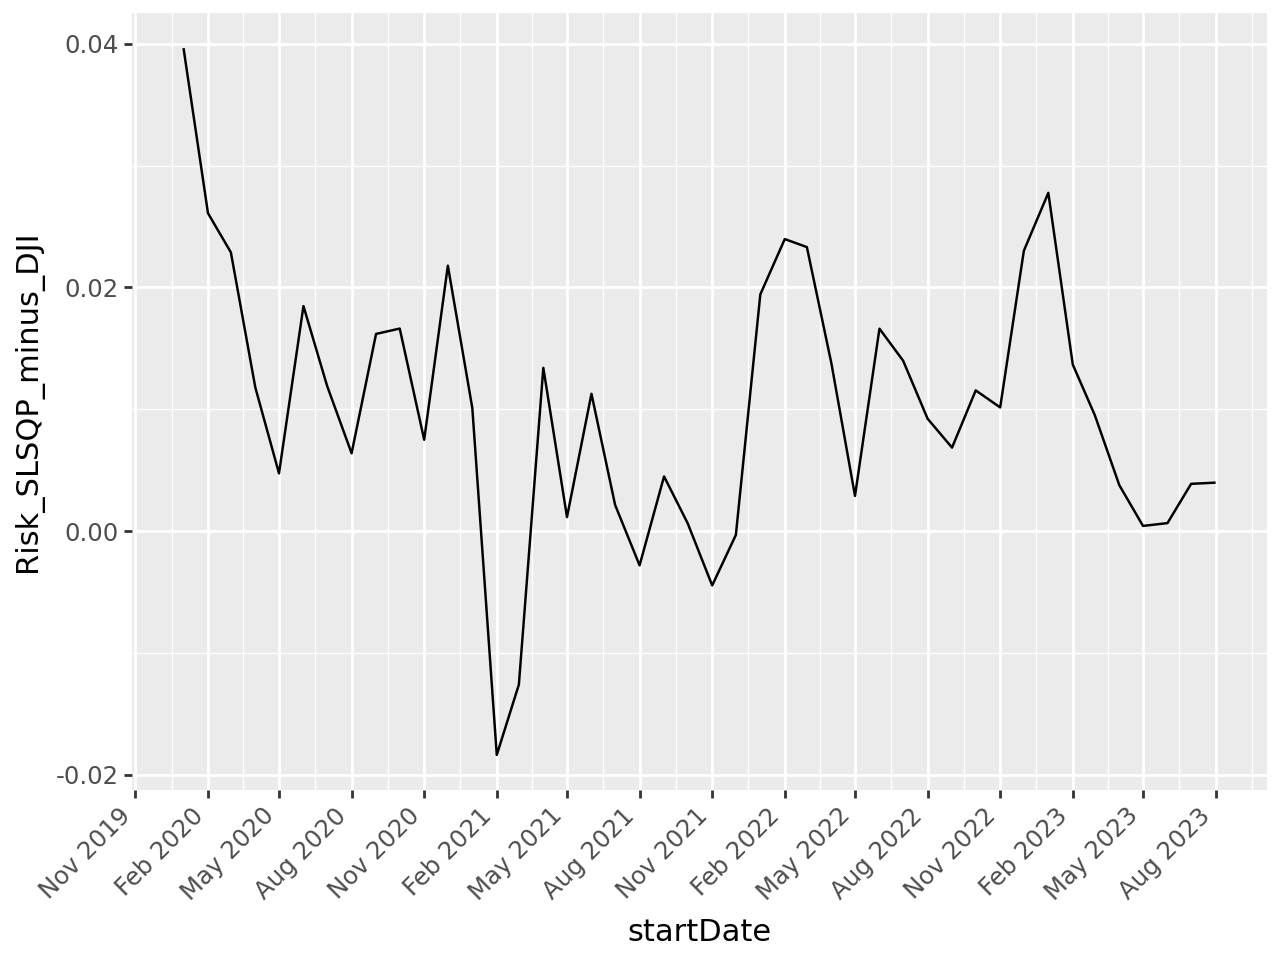

In [213]:
test_results>> mutate(Risk_SLSQP_minus_DJI = _.SLSQP_risk - _.DJI_risk) >> ggplot() + geom_line(aes(x='startDate', y='Risk_SLSQP_minus_DJI'), group=1)+ scale_x_datetime(date_breaks='3 months', date_labels='%b %Y')+ theme(axis_text_x=element_text(angle=45, hjust=1))

In [216]:
test_results.to_excel('excel test results slsqp vs dji.xlsx')

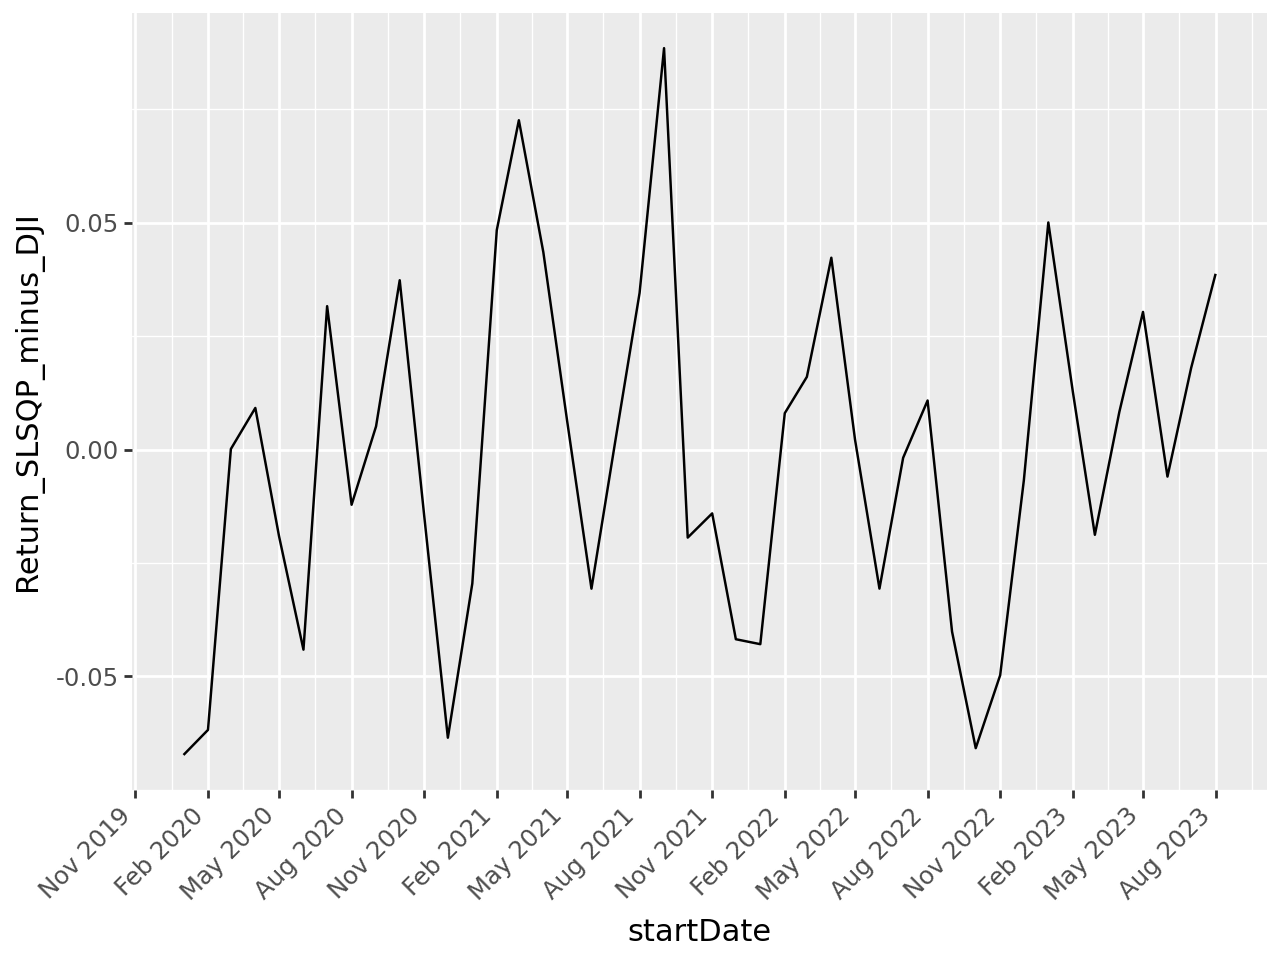

In [215]:
test_results >> mutate(Return_SLSQP_minus_DJI = _.SLSQP_Return - _.DJI_Return) >> ggplot() + geom_line(aes(x='startDate', y='Return_SLSQP_minus_DJI'), group=1)+ \
    scale_x_datetime(date_breaks='3 months', date_labels='%b %Y')+\
          theme(axis_text_x=element_text(angle=45, hjust=1))

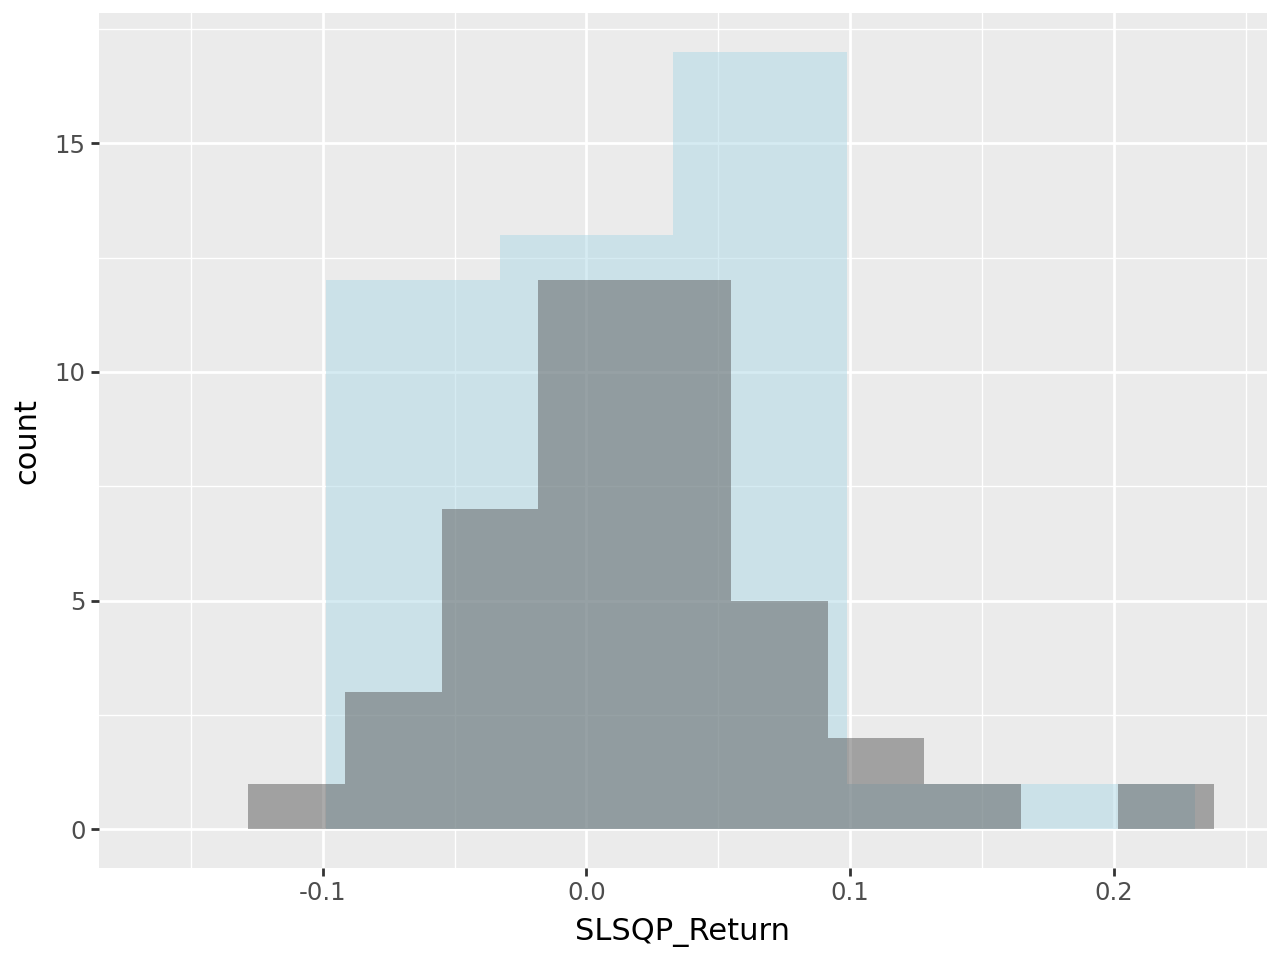

In [201]:
test_results >> ggplot() + geom_histogram(aes(x='SLSQP_Return'), fill='lightblue',alpha=.5) + geom_histogram(aes(x='DJI_Return'),alpha=.5) 

In [ ]:
date(2023,11,24) + relativedelta(months=2)

datetime.date(2024, 1, 24)

In [127]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Example date
date = datetime(2023, 11, 24)

# Add 2 months
new_date = date + relativedelta(months=2)

print("Original date:", date)
print("New date:", new_date)


Original date: 2023-11-24 00:00:00
New date: 2024-01-24 00:00:00


Termina Ejemplo Personal

In [23]:
from scipy.stats import shapiro , ranksums

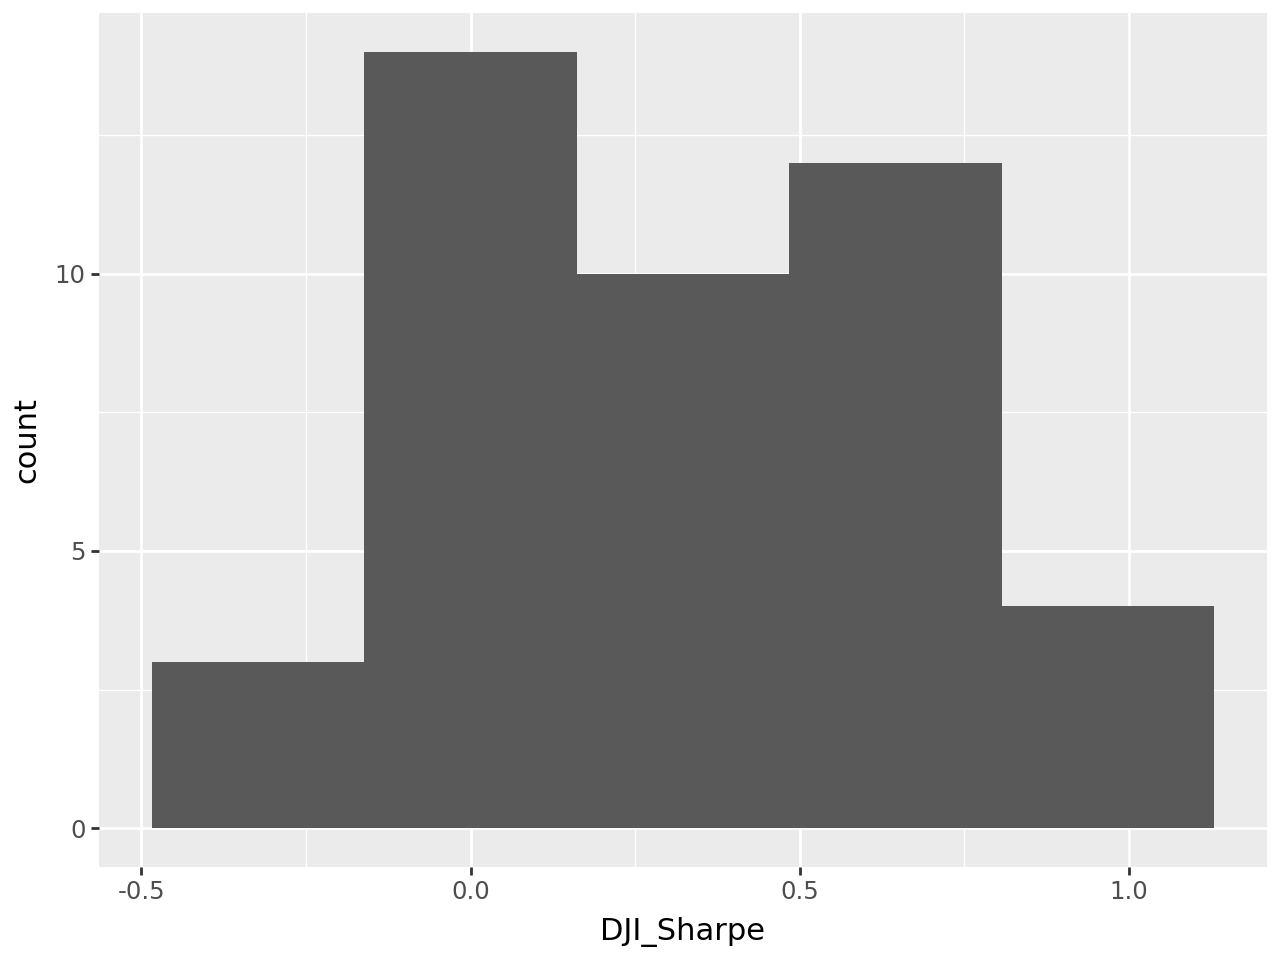

In [24]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1)>>\
        filter(_.BestPortSharpe_over_DJI_Sharpe > -100) >> ggplot() + geom_histogram(aes(x='DJI_Sharpe'))

In [25]:
df_testNormal=startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1)#>>\
        #filter(_.BestPortSharpe_over_DJI_Sharpe > -100) #>> shapiro(_.BestPortSharpe_over_DJI_Sharpe)


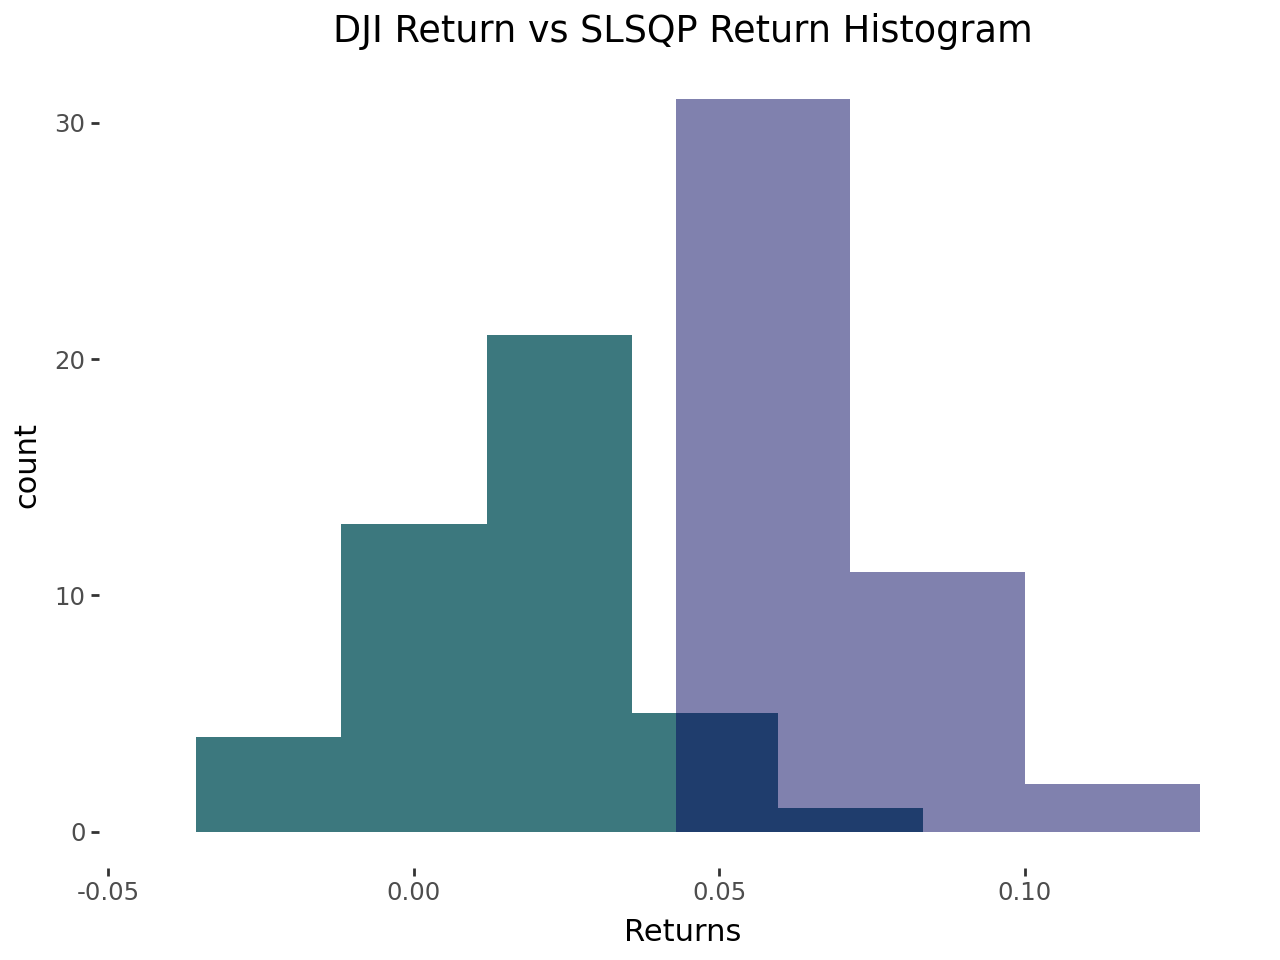

In [26]:

histogram_SLSQP_DJI=df_testNormal >> ggplot() + geom_histogram(aes(x='DJI_return'), fill='#3C787E') + geom_histogram(df_testNormal,aes(x='BestPort_return'), 
                                                                                                                     fill='#03045e', alpha=.5 ) +\
labs(title='DJI Return vs SLSQP Return Histogram') +  theme(panel_background=element_rect(fill='white')) +labs(x='Returns')
histogram_SLSQP_DJI


In [152]:
histogram_SLSQP_DJI.save(filename='Hist SLSQP vs DJI_v2',dpi=1000)

Bootstrap test

## Testing Returns

In [87]:
# does not pass normality test
shapiro(df_testNormal.BestPort_return)

ShapiroResult(statistic=0.9163783940379655, pvalue=0.0036106074817735343)

In [86]:
# passes normality test
shapiro(df_testNormal.DJI_return)

ShapiroResult(statistic=0.9817597368794481, pvalue=0.7041181805662426)

### Bootstrap 

In [27]:
df_testNormal.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights,DJI_Sharpe,BestPort_Sharpe,BestPortSharpe_over_DJI_Sharpe
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[9.256376047594994e-18, 0.10720985847340586, 0...",0.559137,1.288177,1.303866
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[1.3349082920008378e-16, 0.09584736501171755, ...",0.546560,1.261025,1.307205


In [28]:
import numpy as np

# Sample data
np.random.seed(42)
data1 =  df_testNormal.DJI_return # Sample 1
data2 = df_testNormal.BestPort_return  # Sample 2

# Function to calculate bootstrap means
def bootstrap_means(data1, data2, n_bootstrap=10_000):
    bootstrap_diff_means = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        mean_diff = np.mean(sample1) - np.mean(sample2)
        bootstrap_diff_means.append(mean_diff)
    return np.array(bootstrap_diff_means)

# Perform bootstrap
bootstrap_diffs = bootstrap_means(data1, data2)

# Calculate the confidence interval
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Output results
print(f"Bootstrap mean difference: {np.mean(bootstrap_diffs)}")
print(f"95% Confidence Interval: {conf_interval}")


Bootstrap mean difference: -0.04960561690115907
95% Confidence Interval: [-0.05771957 -0.04142064]


In [134]:
abs(np.percentile(bootstrap_diffs, [95]))

array([0.04278146])

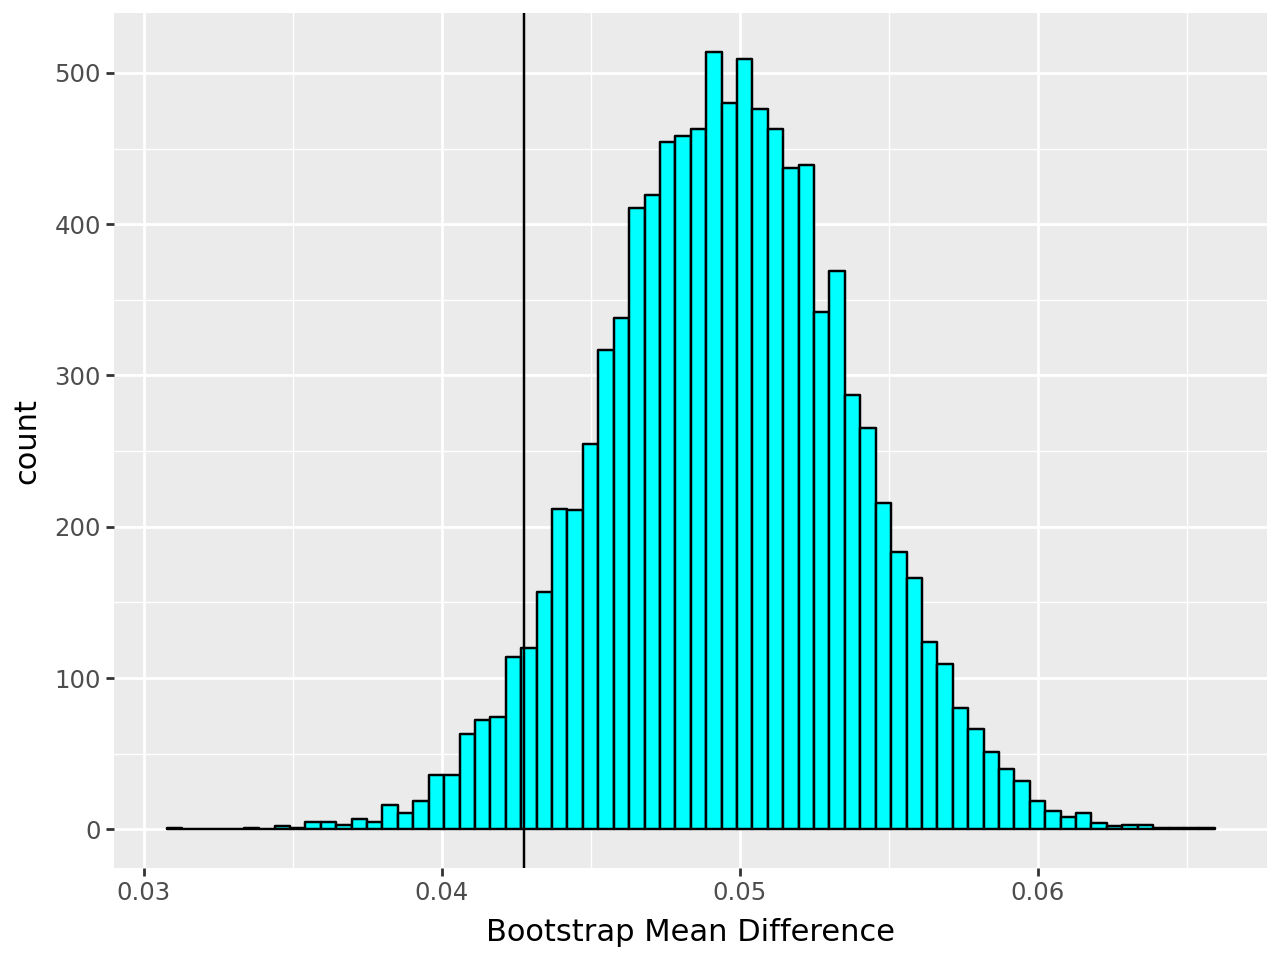

In [29]:
hist_bootstrap_dif_mean=pd.DataFrame({'bt_diff':np.abs(bootstrap_diffs)}) >> ggplot() + geom_histogram(aes(x='bt_diff'), fill='cyan', color='black') + \
labs(x='Bootstrap Mean Difference') + geom_vline(aes(xintercept = abs(np.percentile(bootstrap_diffs, [95]))))
hist_bootstrap_dif_mean

In [132]:
hist_bootstrap_dif_mean.save(filename='Hist Bootstrap Dif Mean',dpi=1000)

In [50]:
import numpy as np

# Sample data
np.random.seed(42)
data1 =  df_testNormal.DJI_return # Sample 1
data2 = df_testNormal.BestPort_return  # Sample 2

# Function to calculate bootstrap means
def bootstrap_means(data1, data2, n_bootstrap=10_000):
    bootstrap_diff_means = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        mean_diff = np.mean(sample2) / np.mean(sample1)
        bootstrap_diff_means.append(mean_diff)
    return np.array(bootstrap_diff_means)

# Perform bootstrap
bootstrap_diffs = bootstrap_means(data1, data2)

# Calculate the confidence interval
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Output results
print(f"Bootstrap mean difference: {np.mean(bootstrap_diffs)}")
print(f"95% Confidence Interval: {conf_interval}")


Bootstrap mean difference: 4.120505626587962
95% Confidence Interval: [2.85193699 6.28464163]


In [51]:
2.85**-1, 6.28**-1

(0.3508771929824561, 0.1592356687898089)

In [83]:
histogram_SLSQP_DJI.save(filename = 'hist_SLSQP_DJI', dpi=1000)

## Testing Risk/St Dev

In [68]:
import numpy as np
from scipy.stats import ks_2samp

# Sample data
np.random.seed(42)
data1 = df_testNormal.DJI_risk
data2 = df_testNormal.BestPort_risk

# Perform Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(data1, data2)

print(f"K-S statistic: {ks_stat}")
print(f"P-value: {p_value}")


K-S statistic: 0.18181818181818182
P-value: 0.4654578921365766


In [89]:
# does not pass normality 
shapiro(df_testNormal.BestPort_risk)

ShapiroResult(statistic=0.8207043926702298, pvalue=8.509077018410583e-06)

In [90]:
# does not pass normality 
shapiro(df_testNormal.DJI_risk)

ShapiroResult(statistic=0.7633244473704796, pvalue=5.081396431283556e-07)

In [100]:
import numpy as np
from scipy.stats import ks_2samp

# Sample data
np.random.seed(42)
data1 = df_testNormal.DJI_risk
data2 = df_testNormal.BestPort_risk

# Perform Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(data1, data2)

print(f"K-S statistic: {ks_stat}")
print(f"P-value: {p_value}")


K-S statistic: 0.18181818181818182
P-value: 0.4654578921365766


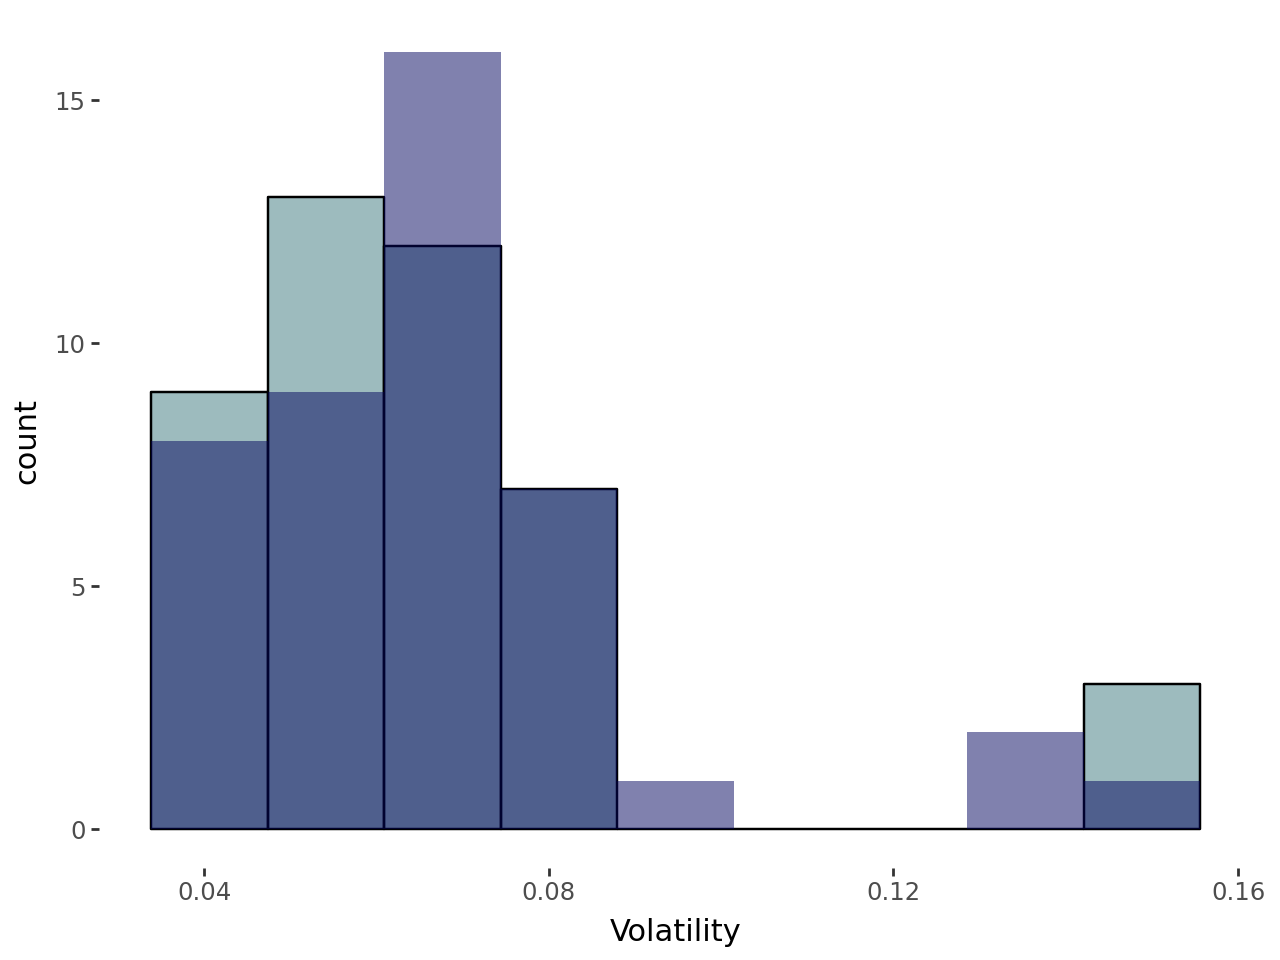

In [146]:
hist_volat_bootstrap=df_testNormal >> ggplot() + geom_histogram(aes(x='DJI_risk'), alpha=.5,fill='#3C787E',color='black') + \
geom_histogram(df_testNormal, aes(x='BestPort_risk'), fill = '#03045e', alpha=.5) + theme(panel_background=element_rect(fill='white')) + \
labs(x='Volatility')

hist_volat_bootstrap


In [147]:
hist_volat_bootstrap.save(filename='Histogram Volatility Bootstrap',dpi=1000)

In [104]:
ranksums(df_testNormal.DJI_risk, df_testNormal.BestPort_risk,'two-sided')

RanksumsResult(statistic=-0.9096397730245827, pvalue=0.3630125160121558)

In [53]:
ranksums(df_testNormal.DJI_return, df_testNormal.BestPort_return,'less')

RanksumsResult(statistic=-7.406221045898697, pvalue=6.497458278915332e-14)

In [50]:
ranksums(df_testNormal.DJI_Sharpe, df_testNormal.BestPort_Sharpe,'less')

RanksumsResult(statistic=-7.173022249118213, pvalue=3.6679962531064045e-13)

In [ ]:

shapiro(df_testNormal['BestPortSharpe_over_DJI_Sharpe'])


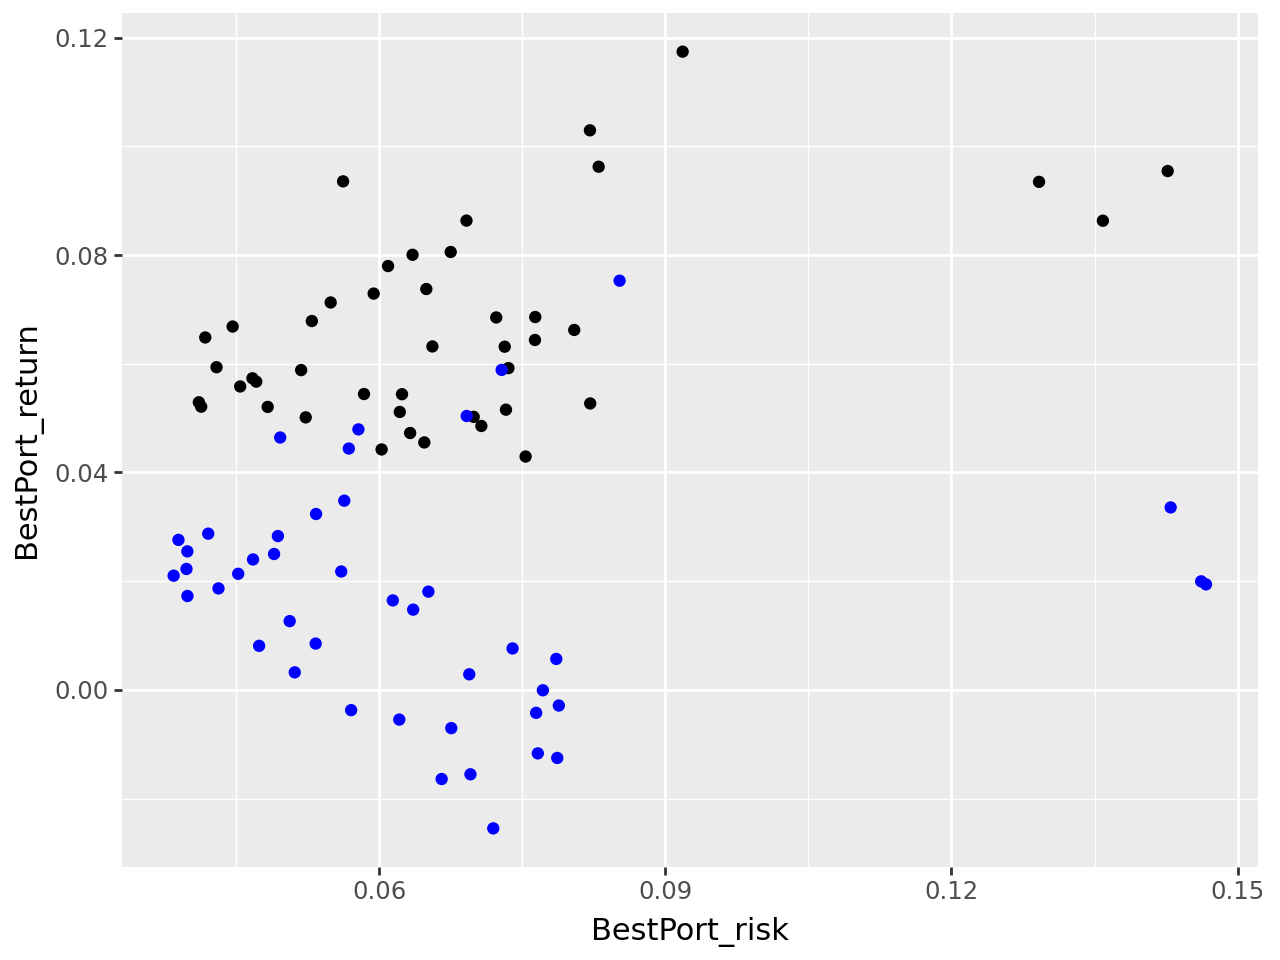

In [492]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1) >> \
         ggplot() + geom_point(aes(x='BestPort_risk', y= 'BestPort_return')) + geom_point(aes(x='DJI_risk',y='DJI_return'), color='blue') #>> filter(_.DJI_Sharpe < 0) #>> \
    #     filter(_.BestPortSharpe_over_DJI_Sharpe >= -100) >> \
    # ggplot() + geom_histogram(aes(x='BestPortSharpe_over_DJI_Sharpe'))

In [ ]:
hist_volat_bootstrap=df_testNormal >> ggplot() + geom_histogram(aes(x='DJI_risk'), alpha=.5,fill='#3C787E',color='black') + \
geom_histogram(df_testNormal, aes(x='BestPort_risk'), fill = '#03045e', alpha=.5) + theme(panel_background=element_rect(fill='white')) + \
labs(x='Volatility')

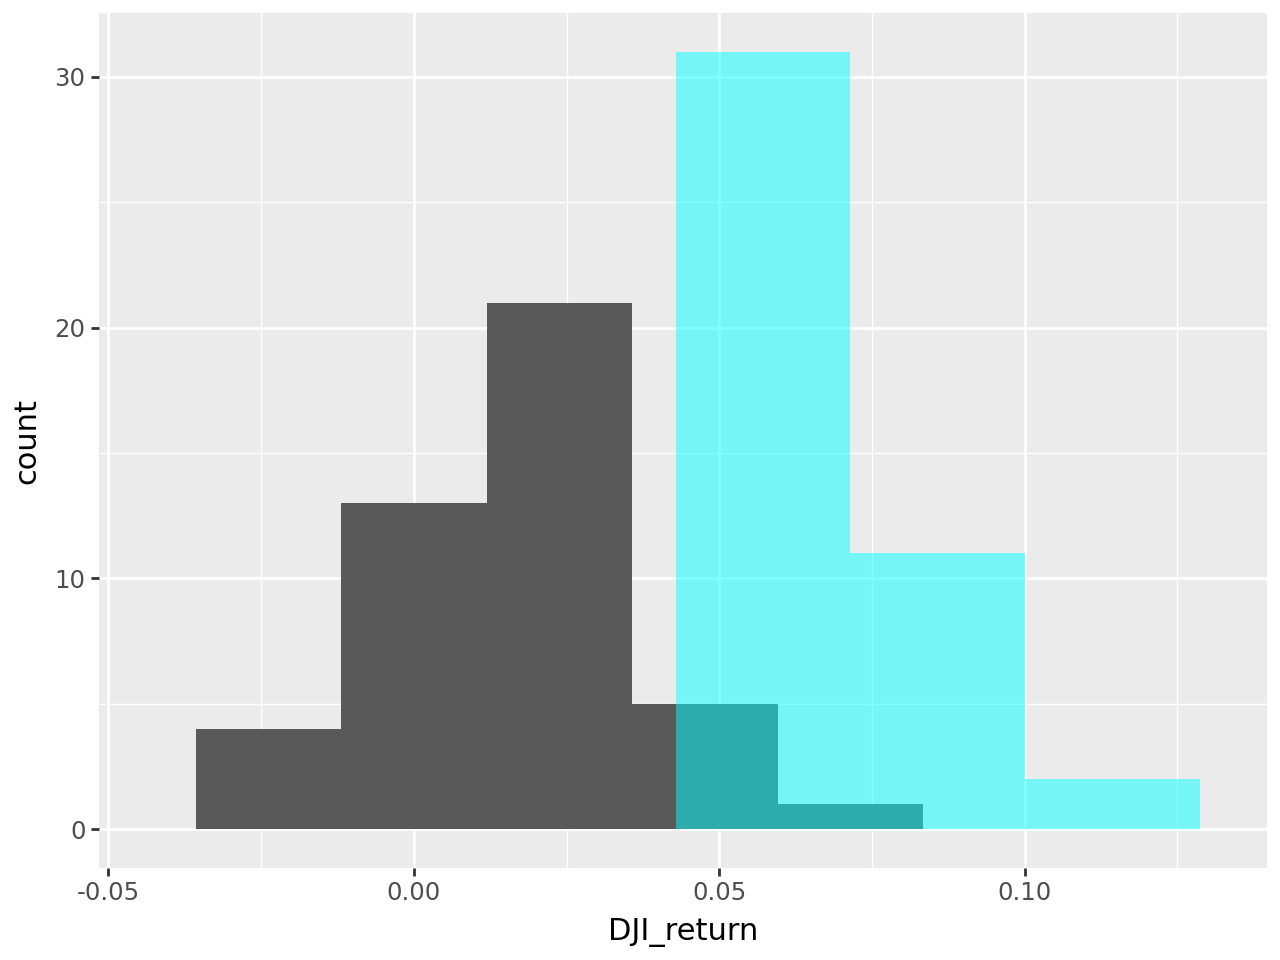

In [157]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1) >>\
    ggplot() + geom_histogram(aes(x='DJI_return')) + geom_histogram(aes(x='BestPort_return'),fill='cyan',alpha=0.5)

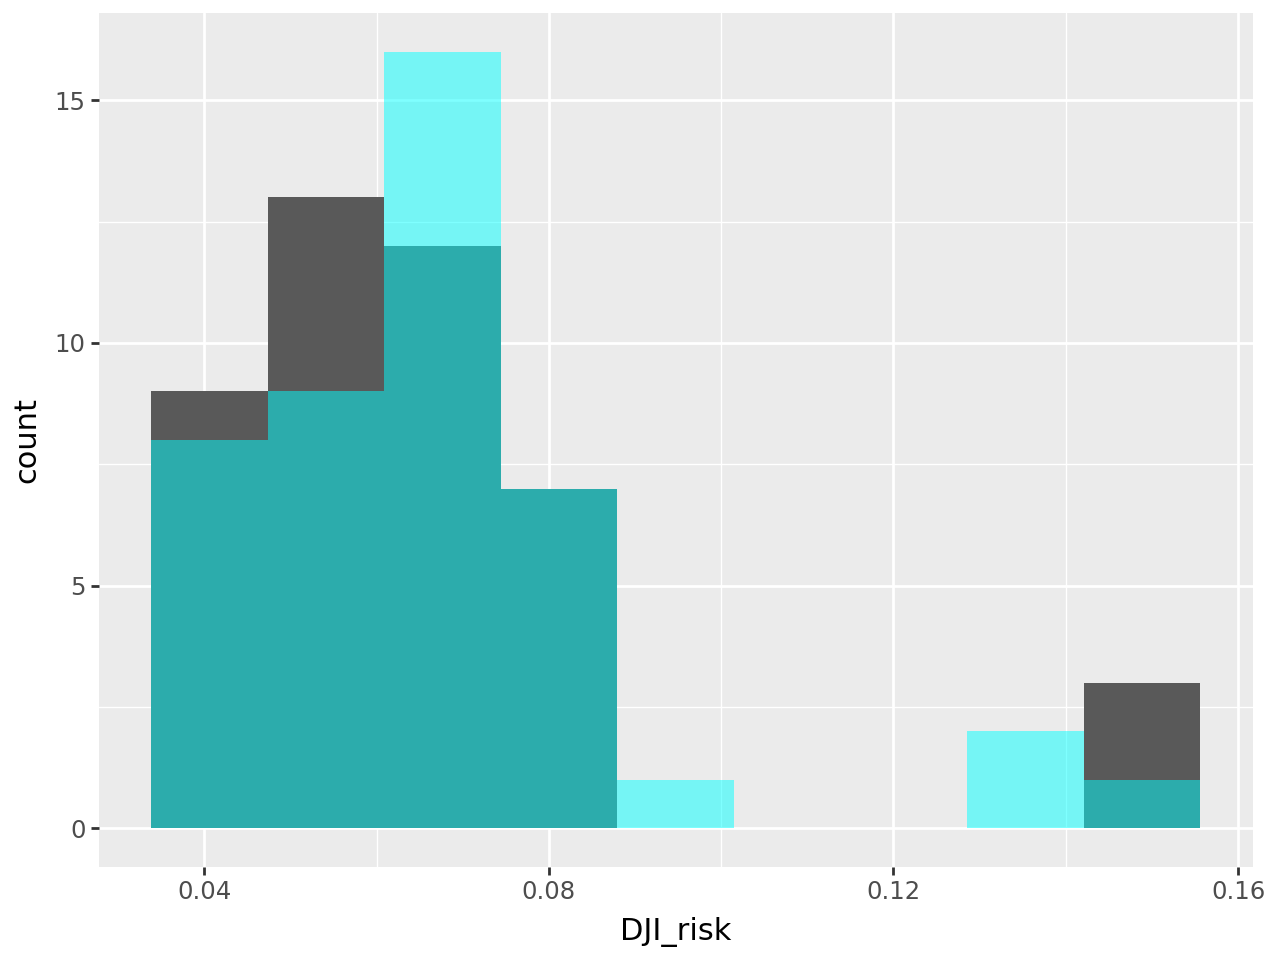

In [501]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1) >>\
    ggplot() + geom_histogram(aes(x='DJI_risk')) + geom_histogram(aes(x='BestPort_risk'),fill='cyan',alpha=0.5)

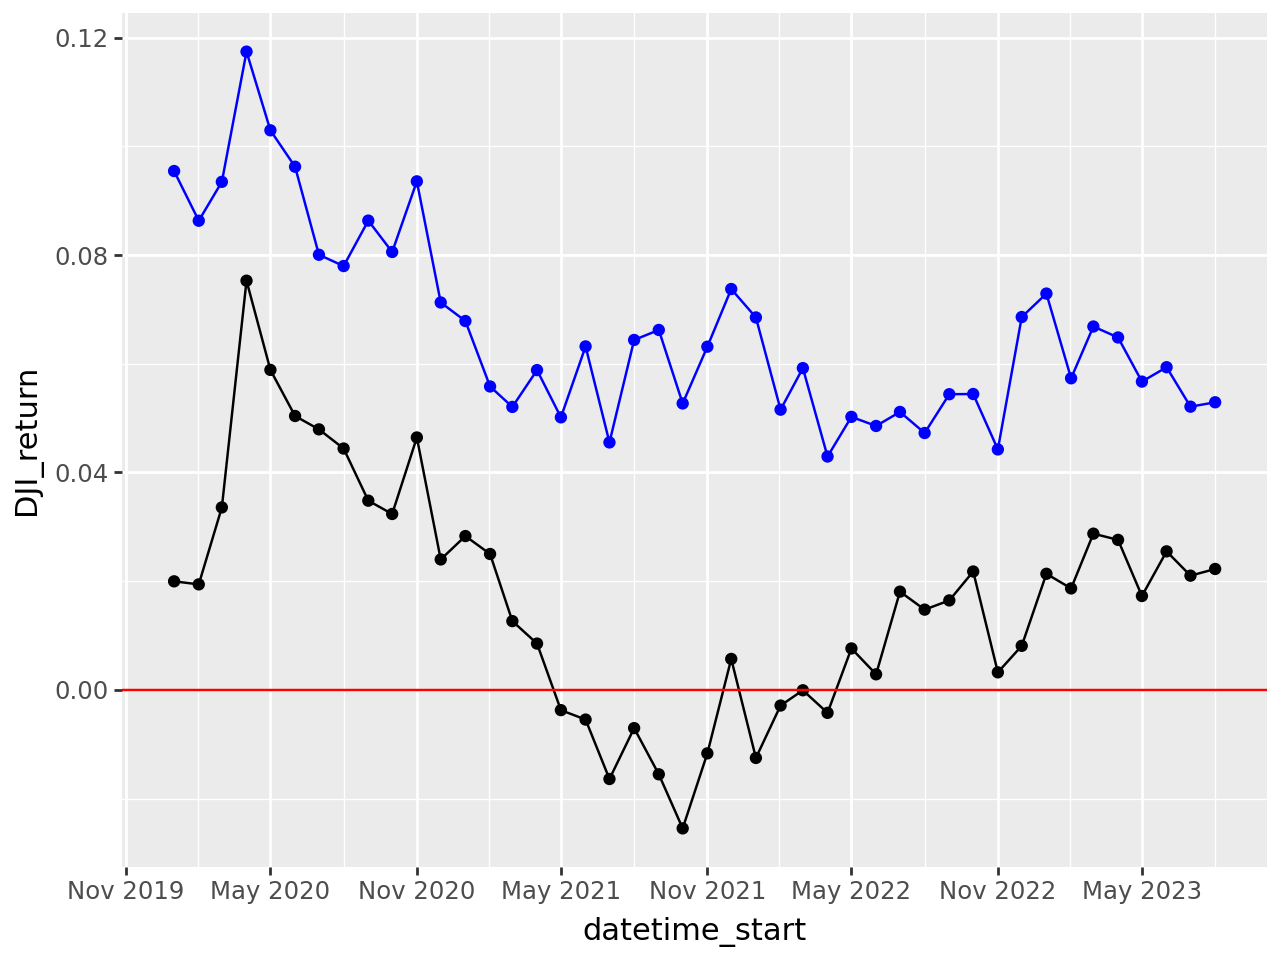

In [ ]:
from mizani.breaks import date_breaks
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1,
    datetime_start = pd.to_datetime(startingDf.startDate)) >>\
    ggplot() + geom_point(aes(x='datetime_start', y ='DJI_return')) + geom_line(aes(x='datetime_start', y ='DJI_return'))+\
    geom_point(aes(x='datetime_start', y ='BestPort_return'), color='blue') + geom_line(aes(x='datetime_start', y ='BestPort_return'),color='blue')+\
    geom_hline(yintercept=0, color='red')+scale_x_date(breaks=date_breaks('6 months'), date_labels='%b %Y')

In [30]:
from mizani.breaks import date_breaks
startingDf2=startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1,
    datetime_start = pd.to_datetime(startingDf.startDate),
    label_x = _.apply(lambda x: f"from: {x['startDate'].strftime('%Y-%m')}\nto: {x['endDate'].strftime('%Y-%m')}", axis=1)
    ) 
startingDf2.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights,DJI_Sharpe,BestPort_Sharpe,BestPortSharpe_over_DJI_Sharpe,datetime_start,label_x
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[6.871402318670006e-16, 0.10720969801744018, 0...",0.559137,1.288177,1.303866,2023-08-01,from: 2023-08\nto: 2024-08
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[1.4887173131496519e-16, 0.09584709481304926, ...",0.546560,1.261025,1.307204,2023-07-01,from: 2023-07\nto: 2024-07


In [ ]:

startingDf2>>\
    ggplot() + geom_col(aes(x='datetime_start', y ='DJI_return')) +\
    geom_point(aes(x='datetime_start', y ='BestPort_return'), color='blue',shape='^',size=2) +\
    geom_hline(yintercept=0, color='red')+scale_x_date(breaks=date_breaks('6 months'), date_labels='%b %Y')+ theme(axis_text_x=element_text(rotation=45, hjust=1))

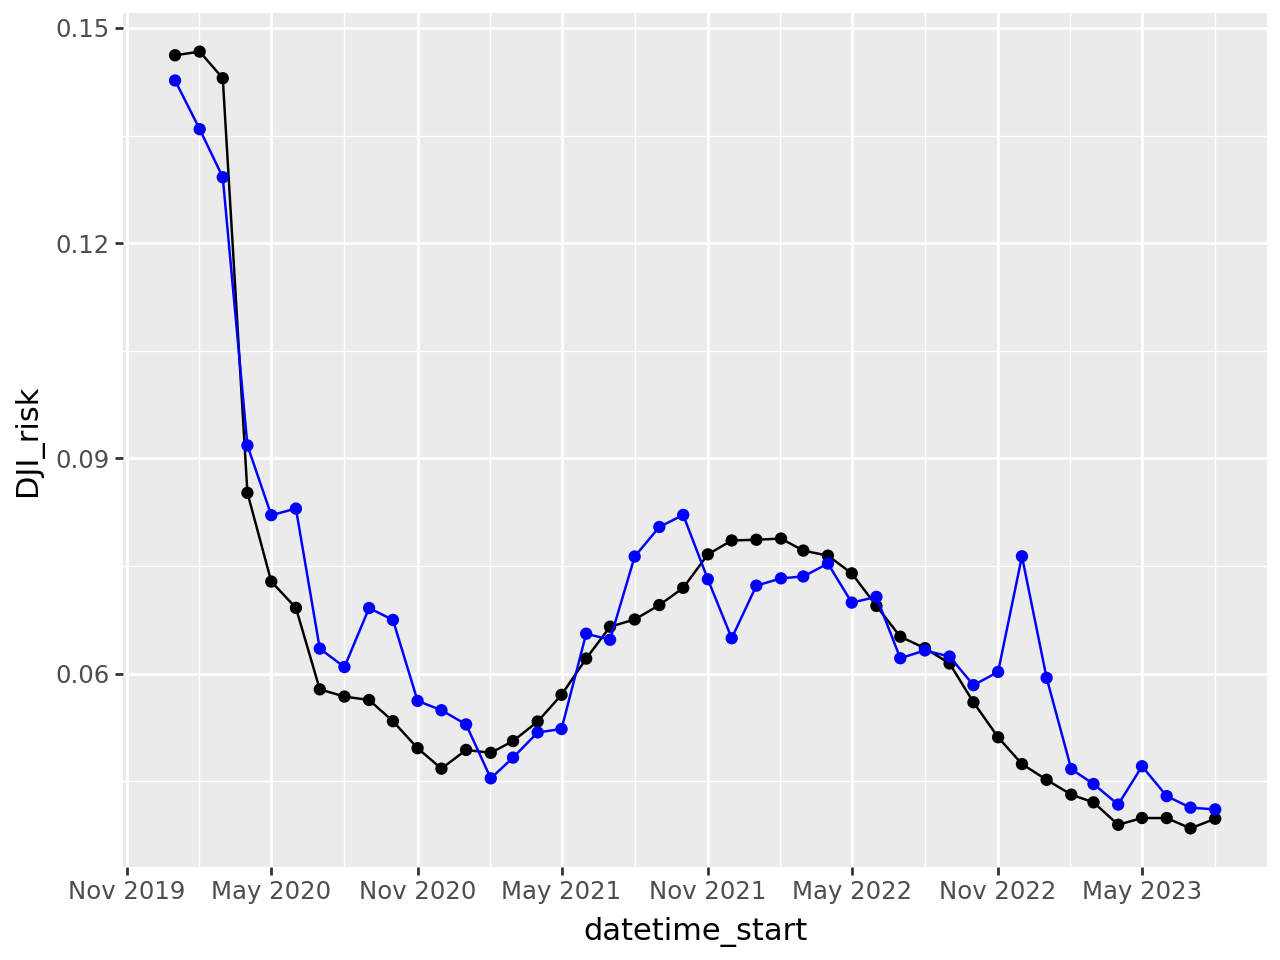

In [ ]:

startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1,
    datetime_start = pd.to_datetime(startingDf.startDate)) >>\
    ggplot() + geom_point(aes(x='datetime_start', y ='DJI_risk')) + geom_line(aes(x='datetime_start', y ='DJI_risk'))+\
    geom_point(aes(x='datetime_start', y ='BestPort_risk'), color='blue') + geom_line(aes(x='datetime_start', y ='BestPort_risk'),color='blue')+\
    scale_x_date(breaks=date_breaks('6 months'), date_labels='%b %Y')

In [115]:
df_best_weights_hist=pd.DataFrame([np.array(x).round(2) for x in startingDf2.Best_Weights])

In [568]:
df_best_weights_hist.columns = training_pct_change.columns

In [95]:
df_best_weights_hist >> filter(_.index==16) >> _.iloc[0,:].reset_index() >> arrange(-_[16]) >> _.head(2)

NameError: name 'df_best_weights_hist' is not defined

not all best portfolios are located in the same place. As a matter of fact, best portfolios have changed throughout time

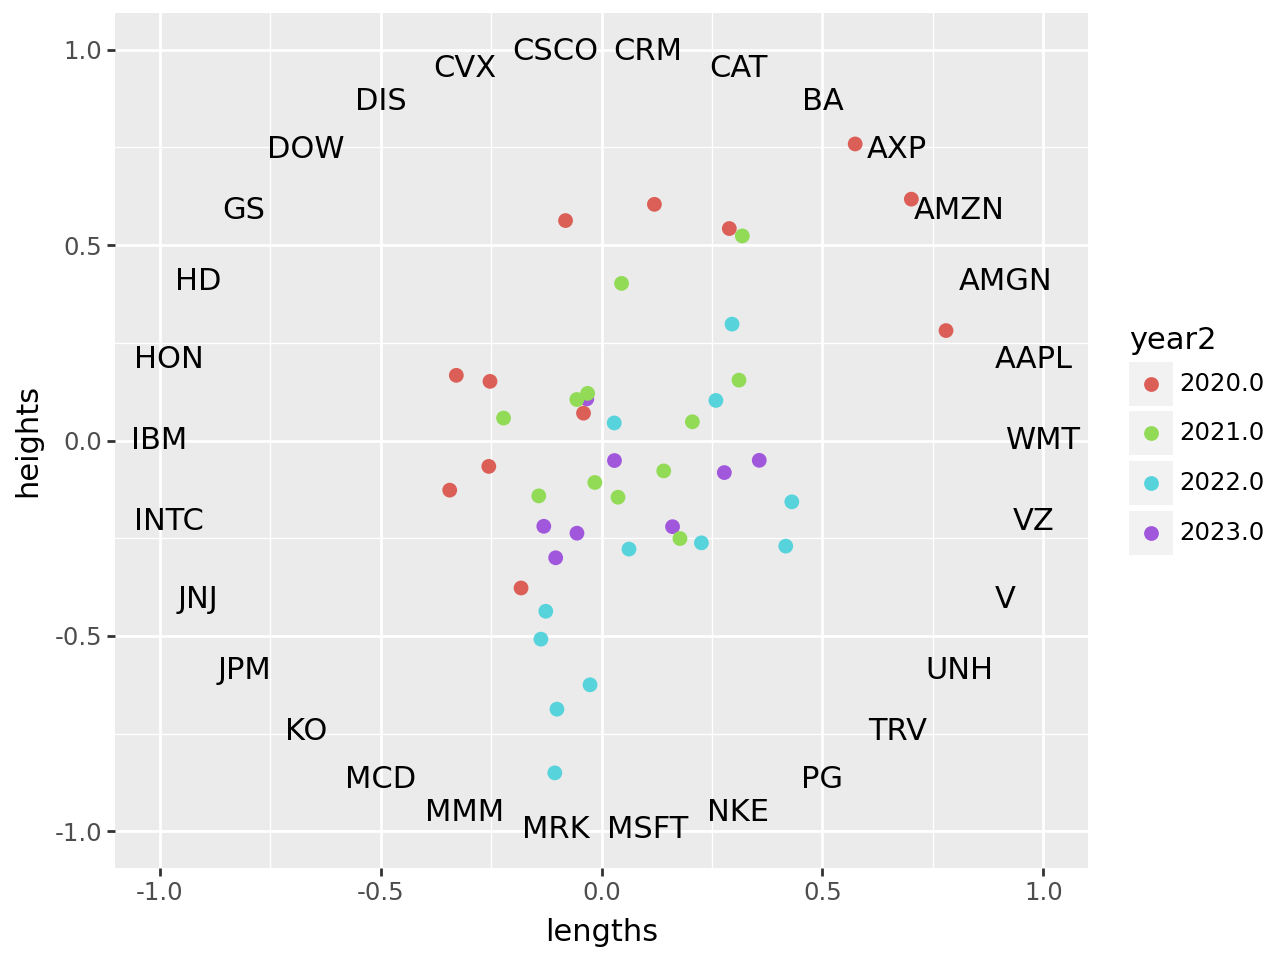

In [116]:
import plotly.express as px 
import plotly.tools as tls 
allx = []
ally = []
for row in df_best_weights_hist.values: 
    x=row.dot(unitCircleDf.lengths)
    y=row.dot(unitCircleDf.heights)
    allx.append(x)
    ally.append(y)

df_ports_hist_coord=pd.DataFrame(np.column_stack((allx,ally,[x.year for x in startingDf2['startDate']])),columns=['x','y','year'])
df_ports_hist_coord2=df_ports_hist_coord >> mutate(year2= _.apply(lambda x: str(x.year),axis=1) )
#print(df_ports_hist_coord2.year2)
p=unitCircleDf >> ggplot() + geom_text(aes(x='lengths',y='heights', label='securities')) + \
    geom_point(df_ports_hist_coord2, aes(x='x',y='y',color='year2'), size=2)

plotly_fig = tls.mpl_to_plotly(p.draw())
p

In [121]:
p=p + theme(axis_text=element_blank()) + labs(y='',x='')

In [122]:
p.save(filename='weights historically slsqp',dpi=1000)

In [616]:
df_ports_hist_coord >> filter(_.y < -0.75)

,x,y
16,-0.105713,-0.850149


### Plotting Historical Returns and Risk against DJI

In [148]:
returns_historically_dji_bestport = startingDf2 >> select(_.label_x, _.DJI_return, _.BestPort_return) 

fig_return_hist_dji_slsqp=returns_historically_dji_bestport.melt(id_vars='label_x') >> mutate(variable = _.apply(lambda x: x['variable'].split('_')[0].replace('BestPort','SLSQP Optim'),axis=1)) >> \
    ggplot() + \
        geom_col(aes(x='label_x', y = 'value'), fill='cyan', color='navajowhite', width=.6) \
        + facet_wrap('variable') + coord_flip() +\
        labs(title = '', 
             subtitle='', 
             y='Expected Return', 
             x='Periods')

## Testing Sharpe Ratio

### testing normality

In [66]:
shapiro(df_testNormal.DJI_Sharpe)

ShapiroResult(statistic=0.9668550304504164, pvalue=0.23336057783575376)

In [67]:
shapiro(df_testNormal.BestPort_Sharpe)

ShapiroResult(statistic=0.9438602226345759, pvalue=0.03265520462519276)

### testing if both have the same distribution

In [ ]:
# two sample K-S test
import numpy as np
from scipy.stats import ks_2samp

# Sample data
np.random.seed(42)
data1 = df_testNormal.DJI_Sharpe
data2 = df_testNormal.BestPort_Sharpe

# Perform Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(data1, data2)

print(f"K-S statistic: {ks_stat}")
print(f"P-value: {p_value}")


K-S statistic: 0.7727272727272727
P-value: 3.4391808449752387e-13


### Bootstrap Sharpe Ratios

In [110]:
import numpy as np

# Sample data
np.random.seed(42)
data1 =  df_testNormal.BestPort_return # Sample 1
data2 = df_testNormal.DJI_return  # Sample 2

# Function to calculate bootstrap means
def bootstrap_means(data1, data2, n_bootstrap=10_000):
    bootstrap_diff_means = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        mean_diff = np.mean(sample1) / np.mean(sample2)
        bootstrap_diff_means.append(mean_diff)
    return np.array(bootstrap_diff_means)

# Perform bootstrap
bootstrap_diffs = bootstrap_means(data1, data2)

# Calculate the confidence interval
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Output results
print(f"Bootstrap mean difference: {np.mean(bootstrap_diffs)}")
print(f"95% Confidence Interval: {conf_interval}")




Bootstrap mean difference: 4.1142491919026005
95% Confidence Interval: [2.82923261 6.25784818]


In [92]:
df_testNormal >> mutate(year_start = _.apply(lambda x: pd.to_datetime(x.startDate).year,axis=1) ) >>group_by( 
_.year_start
) >> summarize(slsqp_over_dji = np.percentile( _.BestPortSharpe_over_DJI_Sharpe,[50]))

,year_start,slsqp_over_dji
0,2020,0.873744
1,2021,-3.331763
2,2022,2.092524
3,2023,1.305536


In [152]:
returns_historically_dji_bestport >> filter(_.DJI_return > 0) >> mutate(SLSQP_over_DJI = _.BestPort_return/_.DJI_return)

,label_x,DJI_return,BestPort_return,SLSQP_over_DJI
0,from: 2023-08\nto: 2024-08,0.022239,0.052910,2.379096
0,from: 2023-07\nto: 2024-07,0.021005,0.052103,2.480485
0,from: 2023-06\nto: 2024-06,0.025479,0.059366,2.329957
0,from: 2023-05\nto: 2024-05,0.017265,0.056715,3.284900
0,from: 2023-04\nto: 2024-04,0.027593,0.064838,2.349797
0,from: 2023-03\nto: 2024-03,0.028735,0.066850,2.326389
0,from: 2023-02\nto: 2024-02,0.018661,0.057325,3.071850
0,from: 2023-01\nto: 2024-01,0.021352,0.072912,3.414804
0,from: 2022-12\nto: 2023-12,0.008096,0.068596,8.472924
0,from: 2022-11\nto: 2023-11,0.003218,0.044233,13.743778


In [176]:
fig_return_hist_dji_slsqp.save(filename = 'ret_dji_slsqp', height=12, width=10, units = 'in', dpi=1000)

# Figures Returns and Risk

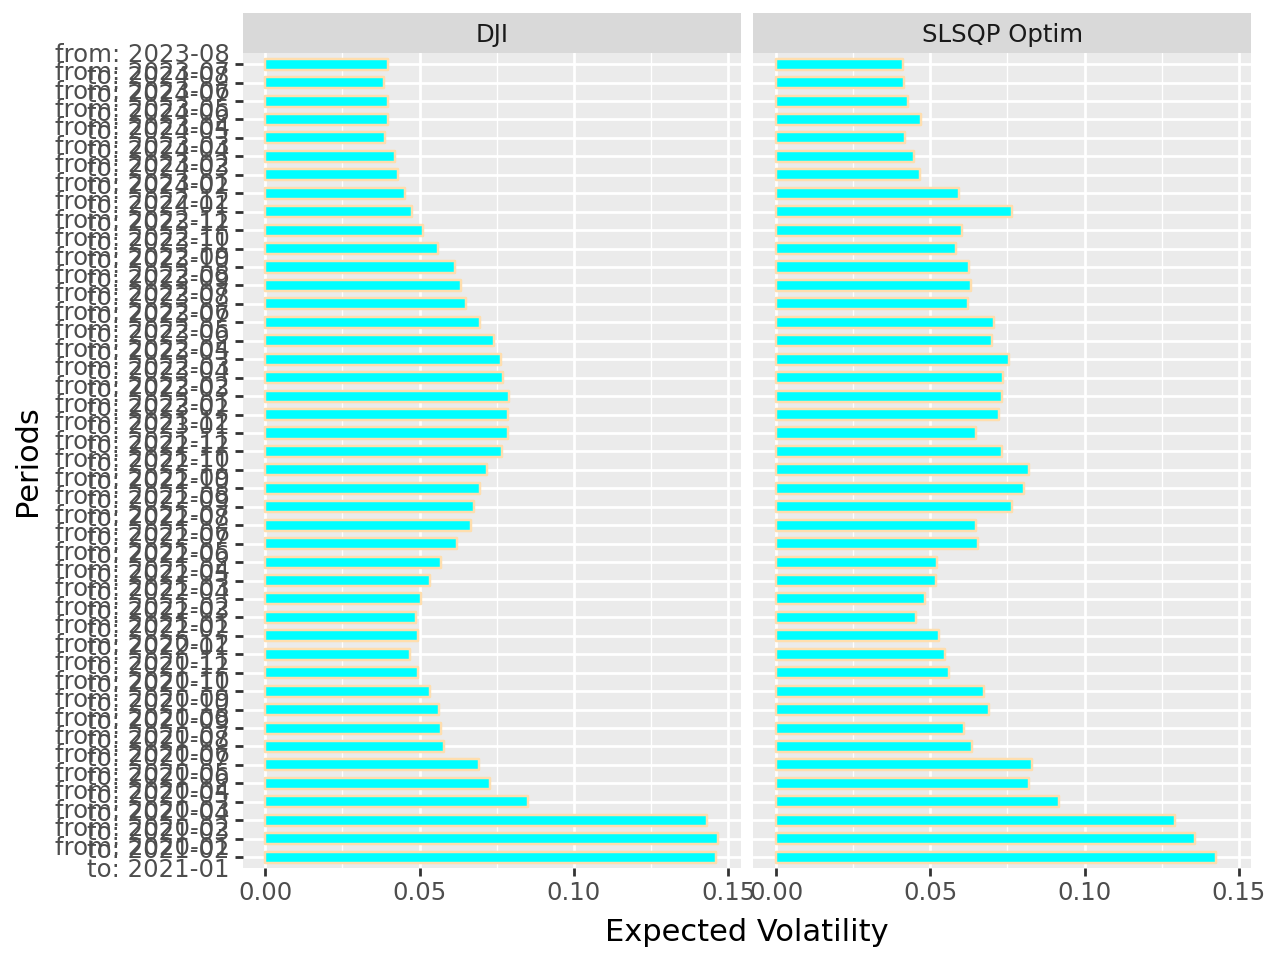

In [85]:
fig_risk_hist_dji_slsqp=startingDf2>> select(_.label_x, _.DJI_risk, _.BestPort_risk) >> _.melt(id_vars='label_x') >> mutate(variable = _.apply(lambda x: x['variable'].split('_')[0].replace('BestPort','SLSQP Optim'),axis=1)) >> \
    ggplot() + \
        geom_col(aes(x='label_x', y = 'value'), fill='cyan', color='navajowhite', width=.6) \
        + facet_wrap('variable') + coord_flip() +\
        labs(title = '', 
             subtitle='', 
             y='Expected Volatility', 
             x='Periods')

fig_risk_hist_dji_slsqp

In [186]:
fig_risk_hist_dji_slsqp.save(filename = 'risk_dji_slsqp', height=12, width=10, units = 'in', dpi=1000)

In [182]:
startingDf2.BestPort_return.describe()

count    44.000000
mean      0.066348
std       0.017573
min       0.042930
25%       0.052548
50%       0.063163
75%       0.074808
max       0.117432
Name: BestPort_return, dtype: float64

In [184]:
startingDf2.DJI_return.describe()

count    44.000000
mean      0.016762
std       0.021262
min      -0.025493
25%       0.002121
50%       0.018364
75%       0.027768
max       0.075283
Name: DJI_return, dtype: float64

In [86]:
startingDf2.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights,DJI_Sharpe,BestPort_Sharpe,BestPortSharpe_over_DJI_Sharpe,datetime_start,label_x
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[0.0, 0.10721022306086941, 0.07528899563315092...",0.559137,1.288177,1.303866,2023-08-01,from: 2023-08\nto: 2024-08
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[3.994694833866124e-16, 0.09584756001604344, 0...",0.546560,1.261025,1.307204,2023-07-01,from: 2023-07\nto: 2024-07


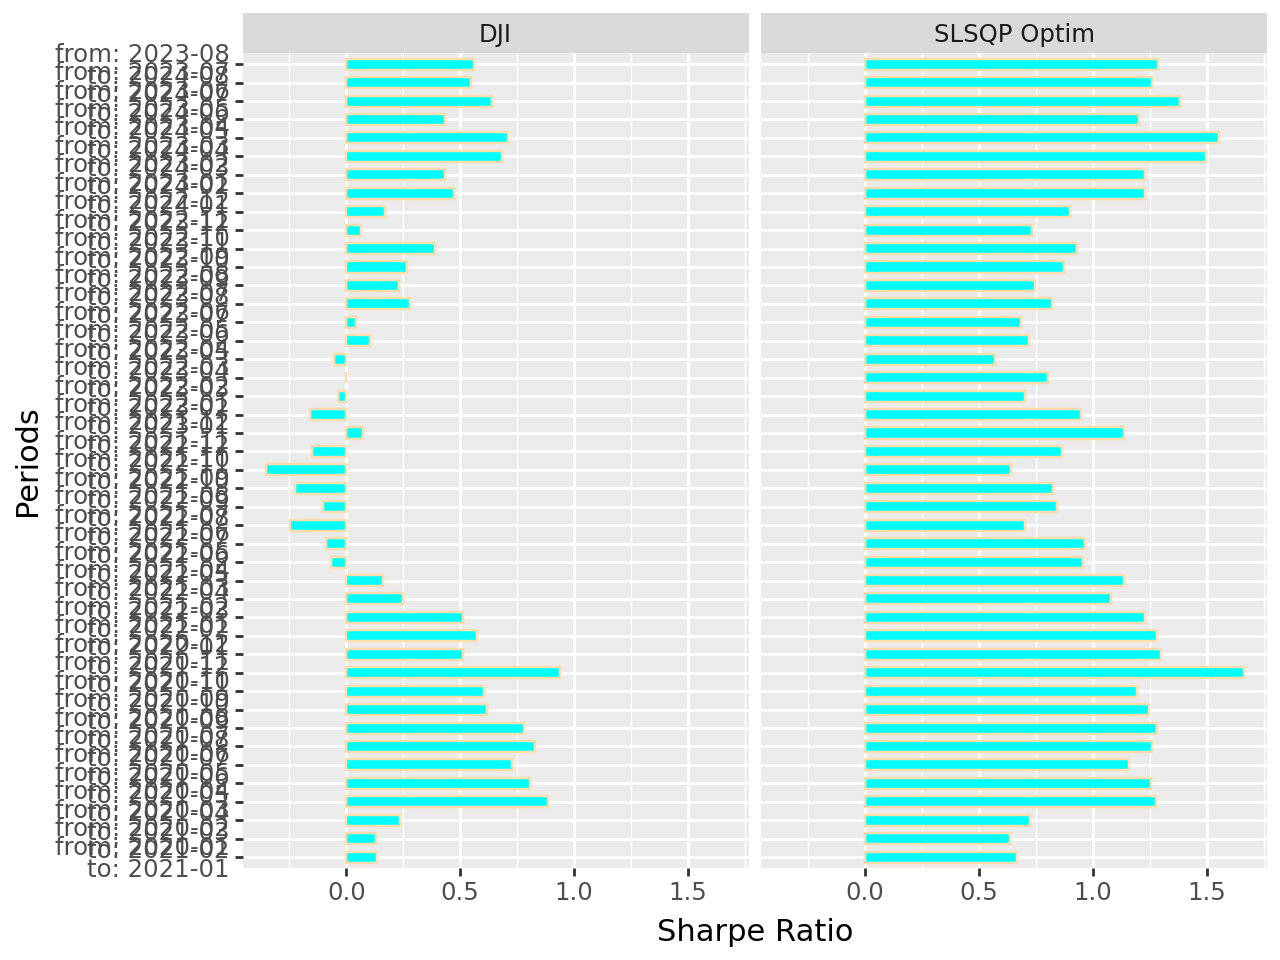

In [90]:
fig_sharpe_hist_dji_slsqp=startingDf2>> select(_.label_x, _.DJI_Sharpe, _.BestPort_Sharpe) >> _.melt(id_vars='label_x') >> mutate(variable = _.apply(lambda x: x['variable'].split('_')[0].replace('BestPort','SLSQP Optim'),axis=1)) >> \
    ggplot() + \
        geom_col(aes(x='label_x', y = 'value'), fill='cyan', color='navajowhite', width=.6) \
        + facet_wrap('variable') + coord_flip() +\
        labs(title = '', 
             subtitle='', 
             y='Sharpe Ratio', 
             x='Periods')

fig_sharpe_hist_dji_slsqp

In [91]:
fig_sharpe_hist_dji_slsqp.save(filename = 'sharpe_dji_slsqp', height=12, width=10, units = 'in', dpi=1000)

In [54]:
isRiskBestPortGreater=case_when(startingDf, {_.BestPort_risk > _.DJI_risk:True, True:False})
startingDf['isRiskBestPortGreater'] = isRiskBestPortGreater

In [59]:
startingDf['isRiskBestPortGreater']=[x for x in isRiskBestPortGreater]

In [61]:
startingDf.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights,isRiskBestPortGreater
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[6.871402318670006e-16, 0.10720969801744018, 0...",True
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[1.4887173131496519e-16, 0.09584709481304926, ...",True


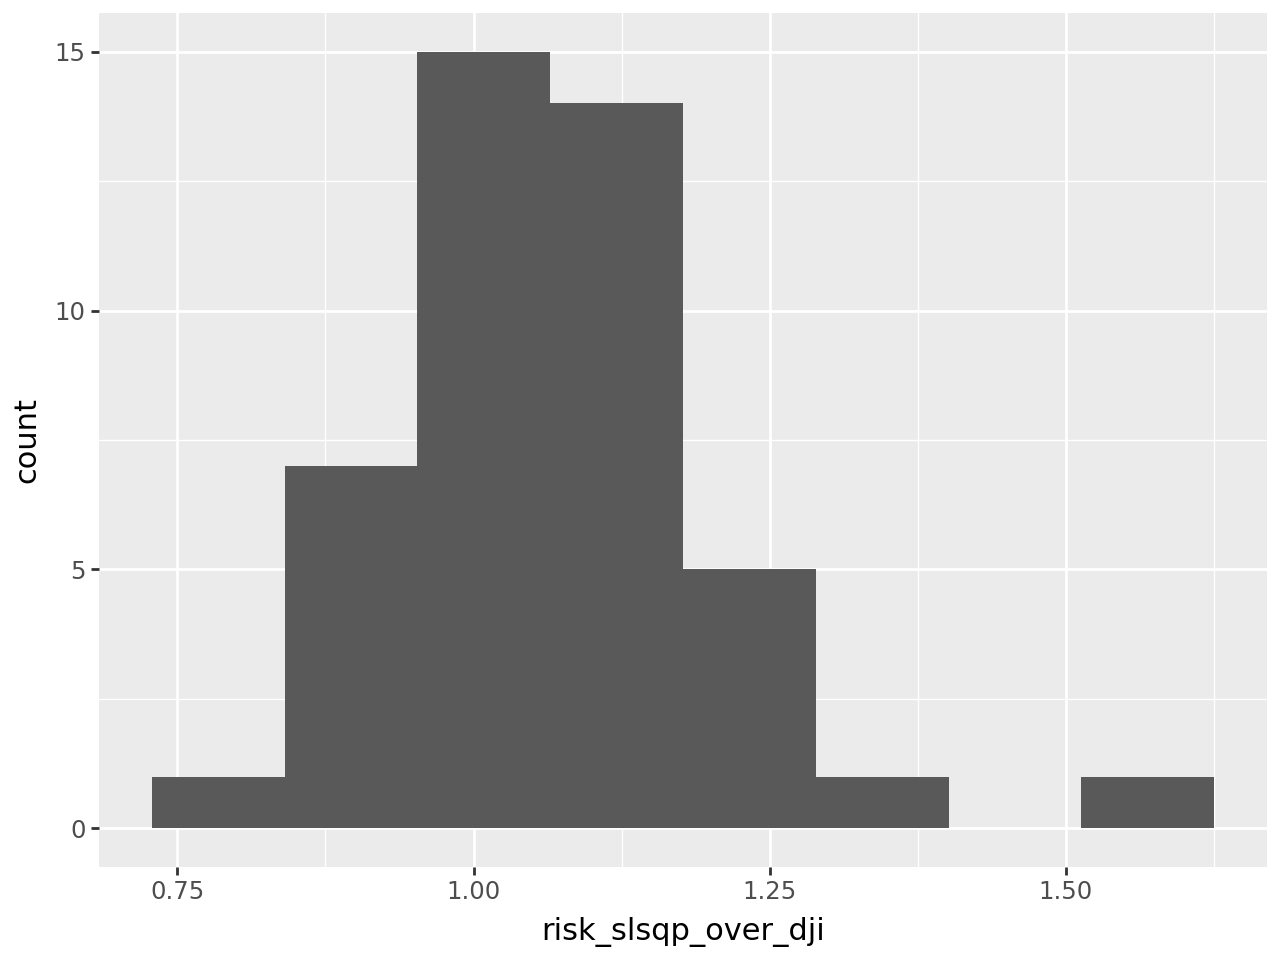

In [64]:
startingDf >> mutate(risk_slsqp_over_dji = _.BestPort_risk/_.DJI_risk
                      ) >> arrange(-_.risk_slsqp_over_dji) >> ggplot() + geom_histogram(aes(x='risk_slsqp_over_dji'))

In [66]:
startingDf>> mutate(risk_slsqp_over_dji = _.BestPort_risk/_.DJI_risk
                      ) >> _['risk_slsqp_over_dji'].describe()

count    44.000000
mean      1.061404
std       0.136441
min       0.826487
25%       0.954613
50%       1.058383
75%       1.130689
max       1.611002
Name: risk_slsqp_over_dji, dtype: float64

In [68]:
from scipy.stats import shapiro , ranksums

In [69]:
startingDf_shapiro=startingDf>> mutate(risk_slsqp_over_dji = _.BestPort_risk/_.DJI_risk
                      )

In [71]:
shapiro(startingDf_shapiro.risk_slsqp_over_dji)

ShapiroResult(statistic=0.892253329846544, pvalue=0.0006343624669648424)

In [37]:
startingDf2>> select(_.label_x, _.DJI_Sharpe, _.BestPort_Sharpe) >> mutate(slsqp_over_dji = _.BestPort_Sharpe/_.DJI_Sharpe) >>\
      arrange(_.slsqp_over_dji)

,label_x,DJI_Sharpe,BestPort_Sharpe,slsqp_over_dji
0,from: 2022-03\nto: 2023-03,-0.001086,0.804986,-741.515195
0,from: 2022-02\nto: 2023-02,-0.036657,0.703467,-19.190423
0,from: 2021-05\nto: 2022-05,-0.065509,0.959019,-14.639578
0,from: 2021-06\nto: 2022-06,-0.088166,0.963746,-10.931023
0,from: 2022-04\nto: 2023-04,-0.055436,0.569828,-10.279011
0,from: 2021-08\nto: 2022-08,-0.104322,0.843502,-8.085539
0,from: 2022-01\nto: 2023-01,-0.159340,0.948266,-5.951203
0,from: 2021-11\nto: 2022-11,-0.152596,0.863156,-5.656490
0,from: 2021-09\nto: 2022-09,-0.223470,0.823212,-3.683760
0,from: 2021-07\nto: 2022-07,-0.246604,0.703388,-2.852302


In [82]:
startingDf.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights,isRiskBestPortGreater
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[6.871402318670006e-16, 0.10720969801744018, 0...",True
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[1.4887173131496519e-16, 0.09584709481304926, ...",True


## Identificando Cambios de Pesos

In [87]:
df_cambiosDePesos=pd.DataFrame(startingDf.Best_Weights.tolist(), index=startingDf['startDate'],columns=training_pct_change.columns).round(2)

### Cada anho en Promedio cuales fueron las empresas que mas pesos se les dio

In [104]:
df_cambiosDePesos.reset_index().melt(id_vars='startDate') >> mutate(anho = _.apply(lambda x: x['startDate'].year,axis=1)) >> \
group_by(_.anho, _.variable) >> summarize(promedios_pesos = _.value.mean()) >> filter(_.promedios_pesos != 0) >> _.to_excel('pesos en el tiempo.xlsx')

In [114]:
df_cambiosDePesos.reset_index().melt(id_vars='startDate') >> mutate(anho = _.apply(lambda x: x['startDate'].year,axis=1)) >> \
filter(_.anho == 2021, _.variable == 'CVX')

,startDate,variable,value,anho
372,2021-12-01,CVX,0.25,2021
373,2021-11-01,CVX,0.42,2021
374,2021-10-01,CVX,0.45,2021
375,2021-09-01,CVX,0.58,2021
376,2021-08-01,CVX,0.50,2021
377,2021-07-01,CVX,0.36,2021
378,2021-06-01,CVX,0.50,2021
379,2021-05-01,CVX,0.38,2021
380,2021-04-01,CVX,0.36,2021
381,2021-03-01,CVX,0.25,2021


In [115]:
df_cambiosDePesos.reset_index().melt(id_vars='startDate') >> mutate(anho = _.apply(lambda x: x['startDate'].year,axis=1)) >> \
filter(_.anho == 2022, _.variable == 'MRK')

,startDate,variable,value,anho
932,2022-12-01,MRK,0.00,2022
933,2022-11-01,MRK,0.07,2022
934,2022-10-01,MRK,0.15,2022
935,2022-09-01,MRK,0.34,2022
936,2022-08-01,MRK,0.31,2022
937,2022-07-01,MRK,0.38,2022
938,2022-06-01,MRK,0.44,2022
939,2022-05-01,MRK,0.63,2022
940,2022-04-01,MRK,0.82,2022
941,2022-03-01,MRK,0.81,2022


### Grafica Pesos

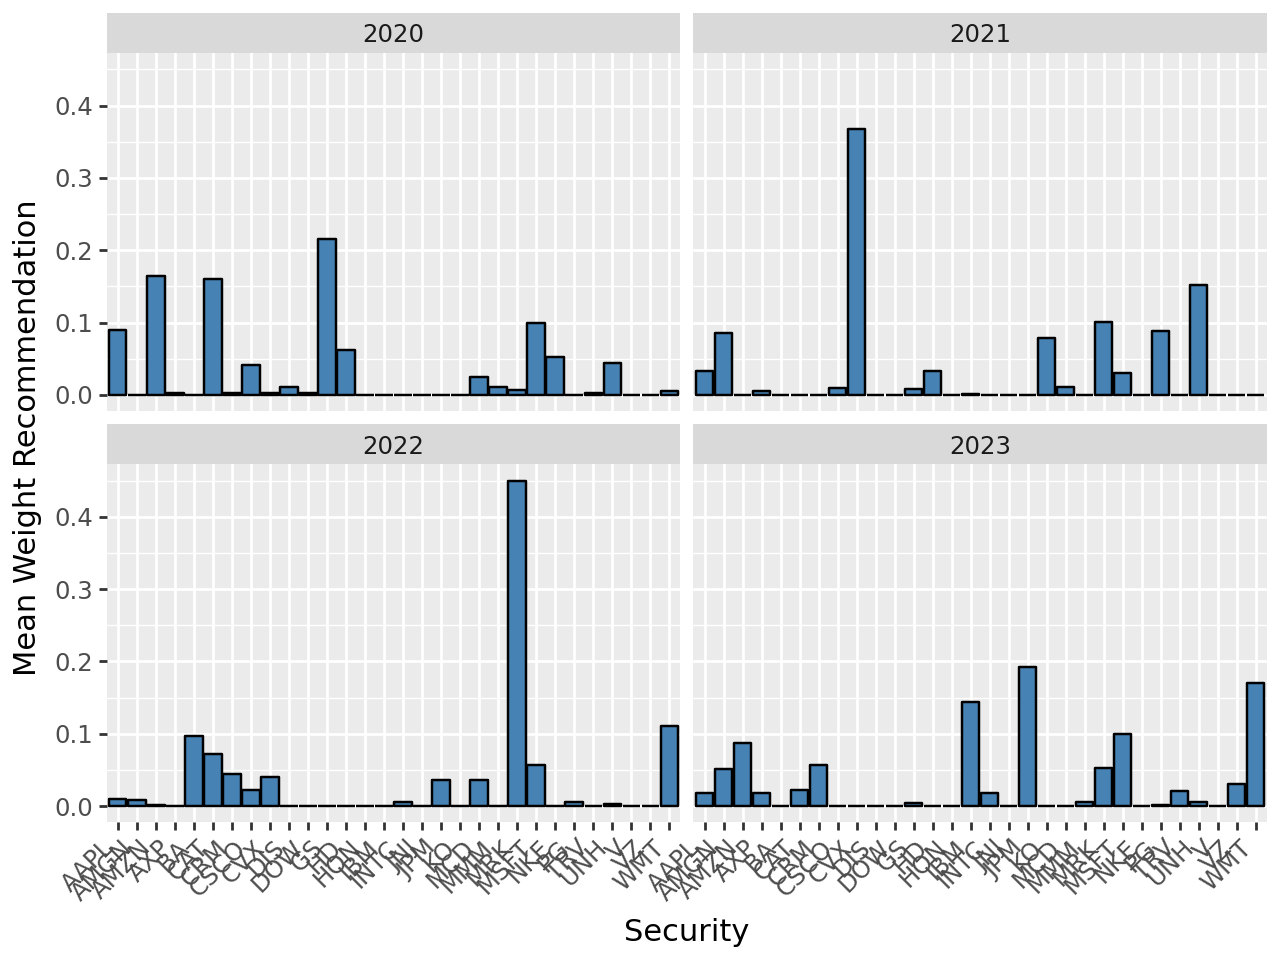

In [118]:
weight_recommendations_time=df_cambiosDePesos.reset_index().melt(id_vars='startDate') >> mutate(anho = _.apply(lambda x: x['startDate'].year,axis=1)) >> \
group_by(_.anho, _.variable) >> summarize(promedios_pesos = _.value.mean()) >> \
ggplot() + geom_col(aes(x='variable', y = 'promedios_pesos'), fill='steelblue', color='black') + facet_wrap('~anho') + \
theme(axis_text_x=element_text(angle=45, hjust=1))+\
labs(y='Mean Weight Recommendation', x = 'Security')
weight_recommendations_time

In [121]:
weight_recommendations_time.save(filename='Mean Weight Recommendations Time',height=8,width=10,dpi=1000)

### CVX Price In Time

In [136]:
CVX_price_time=full_hist_prices["2021-01-01":"2023-12-31"].CVX.reset_index() >> ggplot() + geom_line(aes(x='Date',y='CVX'), color='steelblue') + \
labs(y='price') + geom_vline(xintercept = '2022-01-01')

CVX_price_time.save(filename='CVX price in Time',dpi=1000)

# Linear Plot: SLSQP vs DJI

In [30]:
def fn_dollarChangePortfolio(fn_portReturn: np.array,
                             init_dollar: int = 1_000_000 )->list[float]:    
    """ 
        This function will return the variability of money in time given portfolio returns as input and a dollar amt
    """    
    from copy import deepcopy 
    dollar_current = deepcopy(init_dollar)
    dollar_changes = []

    for x in fn_portReturn: 
        dollar_current*=(1+x)
        dollar_changes.append(dollar_current)

    return dollar_changes

In [31]:
full_hist_prices=fn_get_histPrice(date(2020,1,1),date(2024,11,1))

[*********************100%***********************]  30 of 30 completed


In [32]:
import yfinance as yf

# Define the ticker symbol for Dow Jones Industrial Average
ticker = '^DJI'

# Download historical data
djia_data = yf.download(ticker, start='2023-08-01', end='2024-11-01')
dji_pricehist=missing_days_andIndexTimeZone(djia_data['Close'])

[*********************100%***********************]  1 of 1 completed


In [33]:
dji_price_change_2023Aug_2024Oct=dji_pricehist.pct_change().dropna()

In [ ]:
# returns dataframe of price changes
chg_prices_Aug2023_Jul2024=full_hist_prices >> filter(_.index >= date(2023,8,1).strftime('%Y-%m-%d'), 
                           _.index < date(2024,11,1).strftime('%Y-%m-%d')) >> _.pct_change().dropna()

In [ ]:
# daily consolidated returns of best portfolio (vector of returns)
returns_bestPort_consolidated=chg_prices_Aug2023_Jul2024.dot(Weights_Lopez_SLSQP_Best100)

In [68]:
returns_bestPort_consolidated

Date
2023-08-02   -0.008060
2023-08-03   -0.000404
2023-08-04    0.007766
2023-08-07    0.012283
2023-08-08   -0.001395
                ...   
2024-10-25   -0.006707
2024-10-28    0.006164
2024-10-29   -0.005963
2024-10-30   -0.000963
2024-10-31   -0.002793
Length: 327, dtype: float64

In [38]:
chg_prices_Aug2023_Jul2024.tail(2)

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-30,-0.015278,-0.001456,0.009956,0.013497,0.008563,-0.021341,-0.008331,-0.001616,-0.003165,-0.010923,...,-0.013228,0.010604,0.001343,-0.024873,-0.006042,0.005710,0.001477,0.029374,-0.001210,-0.003794
2024-10-31,-0.018209,0.014642,-0.032844,-0.014594,-0.032277,-0.008016,-0.016970,-0.014751,0.005201,0.011780,...,0.007134,-0.023944,-0.060528,0.008895,-0.005898,-0.016594,0.002736,-0.001068,0.020591,0.006880


In [39]:
df1_SLSQP_priceInTime=pd.DataFrame({'dollar':fn_dollarChangePortfolio(returns_bestPort_consolidated), 
              'index': ['SLSQP']}, index=chg_prices_Aug2023_Jul2024.index)

In [40]:
df1_SLSQP_priceInTime.head(2)

,dollar,index
Date,,
2023-08-02,991939.909629,SLSQP
2023-08-03,991539.235147,SLSQP


In [41]:
df2_DJI_priceInTime=pd.DataFrame({'dollar':fn_dollarChangePortfolio(dji_price_change_2023Aug_2024Oct), 
              'index': ['DJI']}, index=chg_prices_Aug2023_Jul2024.index)

In [ ]:
linear_graph_change_DIJ_SLSQP=pd.concat([df1_SLSQP_priceInTime,df2_DJI_priceInTime]) >> filter(_.index <= '2024-09-30') >> _.reset_index() >> mutate(value= _.dollar/1_000_000)>>\
ggplot() + geom_line(aes(x='Date', y='value', color='index'))+\
scale_color_manual(
        values={
            'DJI': 'navajowhite',
            'SLSQP': 'steelblue'
        },
        labels={
            'DJI': 'Dollar Change DJI',
            'SLSQP': 'Dollar Change SLSQP'
        }
    ) + scale_y_continuous(labels=lambda l: [f'${v:,.2f}' for v in l])+ \
    labs(y='Portfolio Total (MM)', title = 'Best Portfolio vs DJI', color='Legend', 
         caption='Best Portfolio almost grew by 40% over a period of 1 year') + \
        theme(plot_background=element_rect(fill='black'), # outside plot
                                                                    text=element_text(color='white'), # all text                                                                    
                                                                    panel_background=element_rect(fill='black'), # inside plot 
                                                                    panel_grid_minor=element_blank(), # take out minor grid 
                                                                    legend_background=element_rect(fill='black'),                                                                     
                                                                    legend_key=element_rect(fill='black'),
                                                                    legend_title=element_text(ha='center')
                                                                    )+ \
        geom_vline(xintercept = '2024-08-01', color='white', linetype='dashed')
                                                                    

In [46]:
pd.concat([df1_SLSQP_priceInTime,df2_DJI_priceInTime]) >> filter(_.index <= '2024-09-30') >> _.to_excel('dataframe_finalCH4.xlsx')

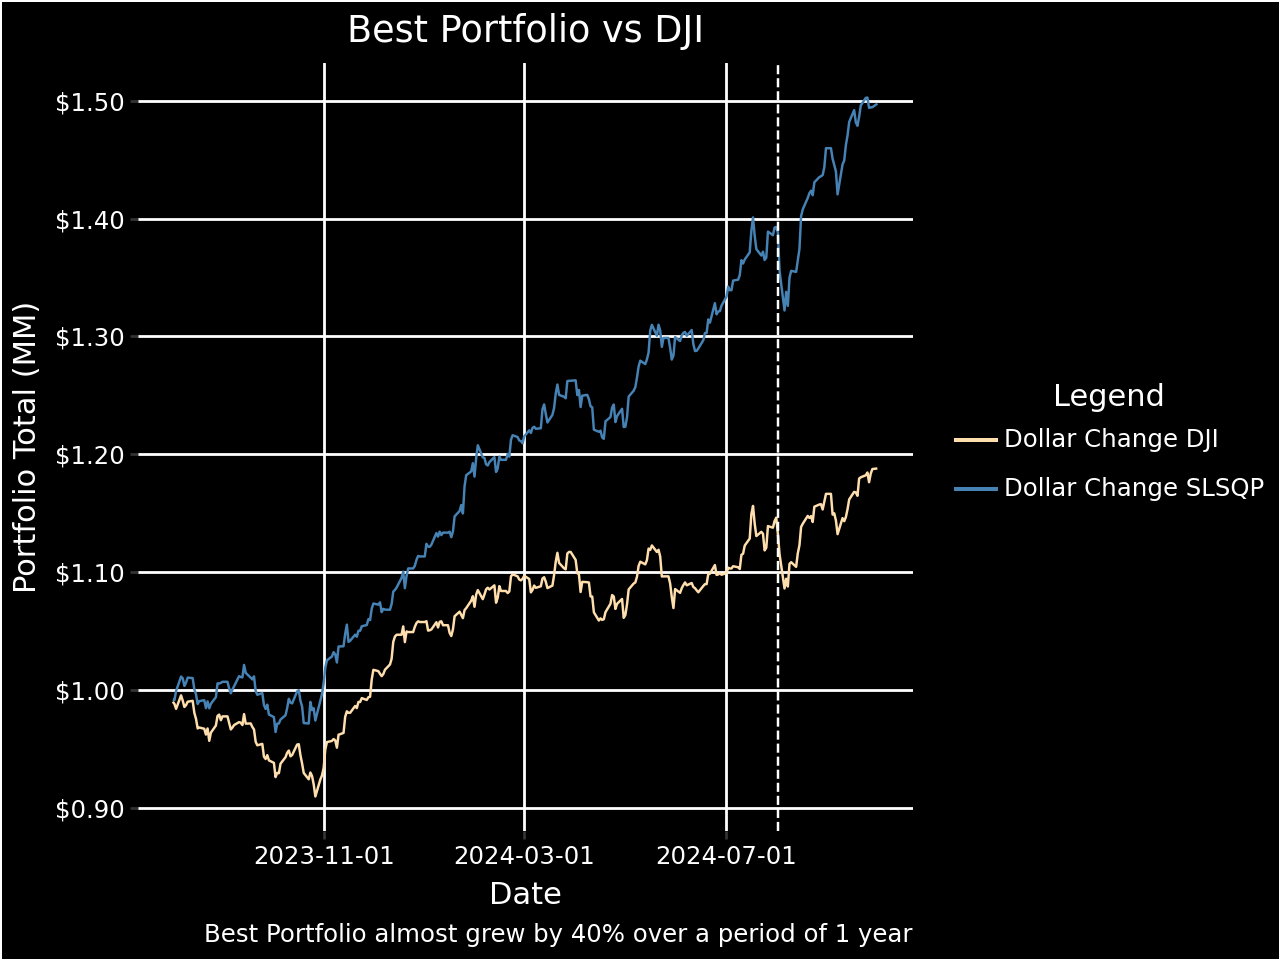

In [48]:
linear_graph_change_DIJ_SLSQP

In [49]:
linear_graph_change_DIJ_SLSQP.save(filename='linear_graph_change_DIJ_SLSQP', height=5, width=8,dpi=1000)

In [197]:
df1_SLSQP_priceInTime >> filter(_.index >= '2024-08-25', _.index <= '2024-09-03')

,dollar,index
Date,,
2024-08-26,1.435132e+06,SLSQP
2024-08-27,1.435943e+06,SLSQP
2024-08-28,1.436871e+06,SLSQP
2024-08-29,1.443432e+06,SLSQP
2024-08-30,1.459674e+06,SLSQP
2024-09-02,1.459674e+06,SLSQP
2024-09-03,1.450746e+06,SLSQP


In [50]:
SLSQP_value_Sept30 = df1_SLSQP_priceInTime >> filter(_.index == '2024-9-30') >> _.loc[:,'dollar'].to_list()[0]

In [51]:
SLSQP_value_Sept30

1497425.788314624

In [52]:
SLSQP_value_Jul31=df1_SLSQP_priceInTime >> filter(_.index == '2024-7-31') >> _.loc[:,'dollar'].to_list()[0]

In [53]:
SLSQP_value_Jul31

1392762.1899818133

In [54]:
SLSQP_value_Sept30/SLSQP_value_Jul31

1.0751482191903683

In [55]:
DJI_value_Sept30 = df2_DJI_priceInTime >> filter(_.index == '2024-9-30') >> _.loc[:,'dollar'].to_list()[0]
DJI_value_Jul31=df2_DJI_priceInTime >> filter(_.index == '2024-7-31') >> _.loc[:,'dollar'].to_list()[0]
DJI_value_Sept30/DJI_value_Jul31

1.0364166945779318

In [226]:
.0209054470/0.006687

3.1262818902347838

In [57]:
returns_bestPort_consolidated.reset_index() >> filter(_.Date>'2024-07-31', _.Date <= '2024-09-30') >> summarize(hola=_[0].std())

,hola
0,0.008994


In [60]:
(SLSQP_value_Sept30/SLSQP_value_Jul31 - 1)/0.008994

8.35537238051682

In [227]:
.004821173540067/0.006471


0.7450430443620769

In [58]:
dji_price_change_2023Aug_2024Oct.reset_index() >> filter(_.Date>'2024-07-31', _.Date <= '2024-09-30') >> summarize(hola=_['Close'].std())

,hola
0,0.008384


In [62]:
(DJI_value_Sept30/DJI_value_Jul31-1)/0.008384

4.343594296031946

In [ ]:
graph_bestPortfolio_vs_DJI=returns_port_training >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> _.reset_index() >> select(_[0,3,4]) >> _.melt(id_vars = 'Date') >> \
mutate(value = _.value/1_000_000)>>\
ggplot() + geom_line(aes(x='Date', y='value', color='variable'))+\
scale_color_manual(
        values={
            'dollarChange_DJI': 'navajowhite',
            'dollarChange_bestPort': 'steelblue'
        },
        labels={
            'dollarChange_DJI': 'Dollar Change DJI',
            'dollarChange_bestPort': 'Dollar Change Best Port'
        }
    ) + scale_y_continuous(labels=lambda l: [f'${v:,.2f}' for v in l])+ \
    labs(y='Portfolio Total (MM)', title = 'Best Portfolio vs DJI', color='Legend', caption='Best Portfolio almost grew by 40% over a period of 1 year') + theme(plot_background=element_rect(fill='black'), # outside plot
                                                                    text=element_text(color='white'), # all text                                                                    
                                                                    panel_background=element_rect(fill='black'), # inside plot 
                                                                    panel_grid_minor=element_blank(), # take out minor grid 
                                                                    legend_background=element_rect(fill='black'),                                                                     
                                                                    legend_key=element_rect(fill='black'),
                                                                    legend_title=element_text(ha='center')
                                                                    )
graph_bestPortfolio_vs_DJI